# Imports


In [1]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm

# Helpful Functions


In [2]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    rankings = np.array(rankings)
    for k in mrr_at_k.keys():
        mrr_at_k_ranking = np.where(rankings <= int(k), 1 / rankings, 0)
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_ranking)
        mrr_at_k[str(k)]['cl'] = [mrr_at_k[str(k)]['score'] - 1.96 * np.std(mrr_at_k_ranking) / np.sqrt(len(mrr_at_k_ranking)),
                                  mrr_at_k[str(k)]['score'] + 1.96 * np.std(mrr_at_k_ranking) / np.sqrt(len(mrr_at_k_ranking))]
    mrr_at_max_ranking = 1 / rankings
    mrr_at_k['max'] = {'score': 0, 'cl': [None, None]}
    mrr_at_k['max']['score'] = np.mean(mrr_at_max_ranking)
    mrr_at_k['max']['cl'] = [mrr_at_k['max']['score'] - 1.96 * np.std(mrr_at_max_ranking) / np.sqrt(len(mrr_at_max_ranking)),
                             mrr_at_k['max']['score'] + 1.96 * np.std(mrr_at_max_ranking) / np.sqrt(len(mrr_at_max_ranking))]
    return mrr_at_k

In [3]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
        
    stratified_mrr_at_k = {}
        
    for category in categories_values:
        stratified_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return stratified_mrr_at_k

In [4]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    rankings = np.array(rankings)
    for k in hits_at_k.keys():
        hits_at_k_ranking = np.where(rankings <= int(k), 1, 0)
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_ranking)
        hits_at_k[str(k)]['cl'] = [hits_at_k[str(k)]['score'] - 1.96 * np.std(hits_at_k_ranking) / np.sqrt(len(hits_at_k_ranking)),
                                  hits_at_k[str(k)]['score'] + 1.96 * np.std(hits_at_k_ranking) / np.sqrt(len(hits_at_k_ranking))]
    hits_at_max_ranking = np.where(rankings <= len(rankings), 1, 0)
    hits_at_k['max'] = {'score': 0, 'cl': [None, None]}
    hits_at_k['max']['score'] = np.mean(hits_at_max_ranking)
    hits_at_k['max']['cl'] = [hits_at_k['max']['score'] - 1.96 * np.std(hits_at_max_ranking) / np.sqrt(len(hits_at_max_ranking)),
                              hits_at_k['max']['score'] + 1.96 * np.std(hits_at_max_ranking) / np.sqrt(len(hits_at_max_ranking))]
    return hits_at_k

In [5]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    stratified_hits_at_k = {}
        
    for category in categories_values:
        stratified_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return stratified_hits_at_k

In [6]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    rankings = np.array(rankings)
    for k in ndcg_at_k.keys():
        ndcg_at_k_ranking = np.where(rankings <= int(k), 1 / np.log2(1 + rankings), 0)
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_ranking)
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k[str(k)]['score'] - 1.96 * np.std(ndcg_at_k_ranking) / np.sqrt(len(ndcg_at_k_ranking)),
                                  ndcg_at_k[str(k)]['score'] + 1.96 * np.std(ndcg_at_k_ranking) / np.sqrt(len(ndcg_at_k_ranking))]
    ndcg_at_max_ranking = 1 / np.log2(1 + rankings)
    ndcg_at_k['max'] = {'score': 0, 'cl': [None, None]}
    ndcg_at_k['max']['score'] = np.mean(ndcg_at_max_ranking)
    ndcg_at_k['max']['cl'] = [ndcg_at_k['max']['score'] - 1.96 * np.std(ndcg_at_max_ranking) / np.sqrt(len(ndcg_at_max_ranking)),
                              ndcg_at_k['max']['score'] + 1.96 * np.std(ndcg_at_max_ranking) / np.sqrt(len(ndcg_at_max_ranking))]
    return ndcg_at_k

In [7]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    stratified_ndcg_at_k = {}
        
    for category in categories_values:
        stratified_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return stratified_ndcg_at_k

# Load data


In [8]:
dfs = {}
# use glob to select all files in test_data/ that don't include "mention_map"
files = glob('test_data/*')
files = [file for file in files if ('mention_map' not in file and 'gpt' not in file)]
for file in files:
    basename = os.path.basename(file)
    lang = basename.split('.')[0]
    if lang == 'ps':
        continue
    dfs[lang] = pd.read_parquet(file)
    dfs[lang]['missing_category'] = dfs[lang]['missing_category'].fillna('present')
    dfs[lang]['number_candidates'] = dfs[lang]['negative_contexts'].apply(lambda x: x.count("'context'") + 1)

In [9]:
dfs['cy']

,source_title,source_ID,target_title,context,section,mention_present,source_lead,first_version,second_version,direct_match,...,roberta_simple_cy,roberta_simple_multilingual,roberta_full_cy,roberta_full_multilingual,roberta_dyn_mask_cy,roberta_only_expansion_cy,roberta_expansion_cy,roberta_full_multilingual-all,roberta_dyn_mask_no_neg_cy,number_candidates
0,1971,169,Wganda,Digwyddiadau\nIonawr\n15 Ionawr - Agorfa'r Arg...,Digwyddiadau,False,19g - 20g - 21g\n1920au 1930au 1940au 1950au 1...,10994651,11878860,True,...,1,1,1,1,2,13,2,1,1,50
1,29_Medi,1076,Cytundeb_Trefaldwyn,29 Medi yw'r deuddegfed dydd a thrigain wedi'r...,Lead,False,29 Medi yw'r deuddegfed dydd a thrigain wedi'r...,11815833,11886178,False,...,3,8,2,6,22,2,4,2,52,54
2,29_Medi,1076,2021,"Digwyddiadau\n1938 - y Deyrnas Unedig, Ffrainc...",Digwyddiadau,False,29 Medi yw'r deuddegfed dydd a thrigain wedi'r...,11815833,11886178,False,...,11,53,3,4,24,7,4,25,28,54
3,29_Medi,1076,Betty_Campbell,"Digwyddiadau\n1938 - y Deyrnas Unedig, Ffrainc...",Digwyddiadau,False,29 Medi yw'r deuddegfed dydd a thrigain wedi'r...,11815833,11886178,False,...,53,53,39,11,52,11,20,44,51,54
4,29_Medi,1076,Cymru,"Digwyddiadau\n1938 - y Deyrnas Unedig, Ffrainc...",Digwyddiadau,False,29 Medi yw'r deuddegfed dydd a thrigain wedi'r...,11815833,11886178,False,...,1,2,2,1,1,1,1,3,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Kylie_Jenner,470946,Instagram,"Ar Fehefin 14, 2019, lansiodd Kylie Cosmetics ...",Gyrfa,False,"Mae Kylie Kristen Jenner (ganwyd Awst 10, 1997...",11891504,11891541,False,...,50,59,75,5,64,63,28,13,100,329
349,Kylie_Jenner,470946,Ariana_Grande,"Ar Fehefin 14, 2019, lansiodd Kylie Cosmetics ...",Gyrfa,False,"Mae Kylie Kristen Jenner (ganwyd Awst 10, 1997...",11891504,11891541,False,...,59,65,33,2,57,64,57,2,40,335
350,Kylie_Jenner,470946,Kanye_West,Dyma'r tro cyntaf i Jenner gydweithio ar gasgl...,Gyrfa,False,"Mae Kylie Kristen Jenner (ganwyd Awst 10, 1997...",11891504,11891541,False,...,81,266,33,26,70,108,81,59,147,334
351,Cyntafanedigaeth,471584,Beibl_1588,"Mae ei hawliad yn gryfach na phob merch, mab i...",Lead,False,Cyntafenedigaeth (Saesneg: Primogeniture o'r L...,11894574,11898457,False,...,1,5,3,1,21,6,1,1,4,23


In [10]:
for key in dfs:
    print(key, dfs[key].columns)

ms Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_simple_ms', 'roberta_simple_multilingual',
       'roberta_full_ms', 'roberta_full_multilingual', 'roberta_dyn_mask_ms',
       'roberta_only_expansion_ms', 'roberta_expansion_ms',
       'roberta_full_multilingual-all', 'roberta_dyn_mask_no_neg_ms',
       'number_candidates'],
      dtype='object')
sk Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_simple_sk', 'roberta_simple_multilingual

## Compute Metrics

In [11]:
columns = ['random_rank', 'bm25_mentions_rank',	'fuzzy_match_rank']
partial_matches = ['roberta']

In [12]:
mrr_at_k = {}
for lang in tqdm(dfs):
    mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())

100%|██████████| 20/20 [00:00<00:00, 119.14it/s]


In [13]:
stratified_mrr_at_k = {}
for lang in tqdm(dfs):
    stratified_mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

100%|██████████| 20/20 [00:00<00:00, 39.12it/s]


In [14]:
hits_at_k = {}
for lang in tqdm(dfs):
    hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())


100%|██████████| 20/20 [00:00<00:00, 154.44it/s]


In [15]:
stratified_hits_at_k = {}
for lang in tqdm(dfs):
    stratified_hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

100%|██████████| 20/20 [00:00<00:00, 42.27it/s]


In [16]:
ndcg_at_k = {}
for lang in tqdm(dfs):
    ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())

100%|██████████| 20/20 [00:00<00:00, 142.73it/s]


In [17]:
stratified_ndcg_at_k = {}
for lang in tqdm(dfs):
    stratified_ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

100%|██████████| 20/20 [00:00<00:00, 41.70it/s]


In [18]:
std = {}
for lang in tqdm(dfs):
    std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            std[lang][column] = dfs[lang][column].std()
        for partial_match in partial_matches:
            if partial_match in column:
                std[lang][column] = dfs[lang][column].std()

100%|██████████| 20/20 [00:00<00:00, 1039.34it/s]


In [19]:
stratified_std = {}
for lang in tqdm(dfs):
    stratified_std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()

100%|██████████| 20/20 [00:00<00:00, 171.56it/s]


# Print Results

In [20]:
fixed_columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'roberta_full_multilingual']
variable_columns = ['roberta_simple_', 'roberta_full_']

In [21]:
# print macro averages for MRR@max and Hits@1
mrr = {column: [] for column in fixed_columns + variable_columns}
hits = {column: [] for column in fixed_columns + variable_columns}

for lang in dfs:
    test_df = dfs[lang]
    for column in fixed_columns:
        ranks = test_df[column].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))
    for column in variable_columns:
        ranks = test_df[column + lang].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))

for column in fixed_columns + variable_columns:
    mrr_scores = mrr[column]
    mrr[column] = {'score': np.mean(mrr_scores), 'sem': np.std(mrr_scores) / np.sqrt(len(mrr_scores)), 'ci': [np.mean(mrr_scores) - 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores)), np.mean(mrr_scores) + 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores))]}
    hits_scores = hits[column]
    hits[column] = {'score': np.mean(hits_scores), 'sem': np.std(hits_scores) / np.sqrt(len(hits_scores)), 'ci': [np.mean(hits_scores) - 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores)), np.mean(hits_scores) + 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores))]}

print('MRR@max')
print(mrr)
print('Hits@1')
print(hits)

MRR@max
{'random_rank': {'score': 0.24330986068725421, 'sem': 0.02052979265684405, 'ci': [0.20307146707983986, 0.28354825429466857]}, 'bm25_mentions_rank': {'score': 0.612448369880645, 'sem': 0.02655428038375251, 'ci': [0.5604019803284901, 0.6644947594327999]}, 'fuzzy_match_rank': {'score': 0.5568672340537323, 'sem': 0.03170634158024996, 'ci': [0.49472280455644235, 0.6190116635510222]}, 'roberta_full_multilingual': {'score': 0.7786052439346645, 'sem': 0.017391323225257594, 'ci': [0.7445182504131596, 0.8126922374561694]}, 'roberta_simple_': {'score': 0.6489047628556013, 'sem': 0.029552063937163493, 'ci': [0.5909827175387609, 0.7068268081724417]}, 'roberta_full_': {'score': 0.7437984275797027, 'sem': 0.016648744642756647, 'ci': [0.7111668880798997, 0.7764299670795057]}}
Hits@1
{'random_rank': {'score': 0.10699223412456471, 'sem': 0.012884771039632413, 'ci': [0.08173808288688518, 0.13224638536224423]}, 'bm25_mentions_rank': {'score': 0.5081926548189039, 'sem': 0.02727761387610821, 'ci': [

In [22]:
mrr = {column: [] for column in fixed_columns + variable_columns}
hits = {column: [] for column in fixed_columns + variable_columns}

for lang in dfs:
    test_df = dfs[lang][dfs[lang]['missing_category'] == 'present']
    for column in fixed_columns:
        ranks = test_df[column].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))
    for column in variable_columns:
        ranks = test_df[column + lang].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))

for column in fixed_columns + variable_columns:
    mrr_scores = mrr[column]
    mrr[column] = {'score': np.mean(mrr_scores), 'sem': np.std(mrr_scores) / np.sqrt(len(mrr_scores)), 'ci': [np.mean(mrr_scores) - 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores)), np.mean(mrr_scores) + 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores))]}
    hits_scores = hits[column]
    hits[column] = {'score': np.mean(hits_scores), 'sem': np.std(hits_scores) / np.sqrt(len(hits_scores)), 'ci': [np.mean(hits_scores) - 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores)), np.mean(hits_scores) + 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores))]}
    
print('MRR@max')
print(mrr)
print('Hits@1')
print(hits)

MRR@max
{'random_rank': {'score': 0.2592569216742168, 'sem': 0.023617690515246755, 'ci': [0.2129662482643332, 0.30554759508410045]}, 'bm25_mentions_rank': {'score': 0.8655935333275353, 'sem': 0.010765959425466798, 'ci': [0.8444922528536204, 0.8866948138014502]}, 'fuzzy_match_rank': {'score': 0.7737064182300879, 'sem': 0.02807221706489066, 'ci': [0.7186848727829022, 0.8287279636772736]}, 'roberta_full_multilingual': {'score': 0.9163877912345184, 'sem': 0.009572389001805862, 'ci': [0.8976259087909789, 0.9351496736780579]}, 'roberta_simple_': {'score': 0.90665564564549, 'sem': 0.009826535959461483, 'ci': [0.8873956351649455, 0.9259156561260344]}, 'roberta_full_': {'score': 0.90560118655408, 'sem': 0.00994212831309665, 'ci': [0.8861146150604106, 0.9250877580477493]}}
Hits@1
{'random_rank': {'score': 0.11536677937539838, 'sem': 0.015468470786215043, 'ci': [0.0850485766344169, 0.14568498211637987]}, 'bm25_mentions_rank': {'score': 0.7985613823876874, 'sem': 0.014432214518205746, 'ci': [0.770

In [23]:
mrr = {column: [] for column in fixed_columns + variable_columns}
hits = {column: [] for column in fixed_columns + variable_columns}

for lang in dfs:
    # include only rows where "missing_category" contains the word "missing"
    test_df = dfs[lang][dfs[lang]['missing_category'].str.contains('missing')]
    for column in fixed_columns:
        ranks = test_df[column].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))
    for column in variable_columns:
        ranks = test_df[column + lang].tolist()
        mrr[column].append(np.mean(1 / np.array(ranks)))
        hits[column].append(np.mean(np.array(ranks) <= 1))
        
for column in fixed_columns + variable_columns:
    mrr_scores = mrr[column]
    mrr[column] = {'score': np.mean(mrr_scores), 'sem': np.std(mrr_scores) / np.sqrt(len(mrr_scores)), 'ci': [np.mean(mrr_scores) - 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores)), np.mean(mrr_scores) + 1.96 * np.std(mrr_scores) / np.sqrt(len(mrr_scores))]}
    hits_scores = hits[column]
    hits[column] = {'score': np.mean(hits_scores), 'sem': np.std(hits_scores) / np.sqrt(len(hits_scores)), 'ci': [np.mean(hits_scores) - 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores)), np.mean(hits_scores) + 1.96 * np.std(hits_scores) / np.sqrt(len(hits_scores))]}
    
print('MRR@max')
print(mrr)
print('Hits@1')
print(hits)

MRR@max
{'random_rank': {'score': 0.23566140907988964, 'sem': 0.019604102966010065, 'ci': [0.19723736726650992, 0.27408545089326936]}, 'bm25_mentions_rank': {'score': 0.42056230169480546, 'sem': 0.02179086349991291, 'ci': [0.37785220923497614, 0.4632723941546348]}, 'fuzzy_match_rank': {'score': 0.39485590372526075, 'sem': 0.028013592396344843, 'ci': [0.33994926262842484, 0.44976254482209665]}, 'roberta_full_multilingual': {'score': 0.6711819388756445, 'sem': 0.01826755993210364, 'ci': [0.6353775214087214, 0.7069863563425676]}, 'roberta_simple_': {'score': 0.4506328172336615, 'sem': 0.028168026764786226, 'ci': [0.3954234847746805, 0.5058421496926425]}, 'roberta_full_': {'score': 0.6169631913255373, 'sem': 0.01872491072724941, 'ci': [0.5802623663001285, 0.6536640163509462]}}
Hits@1
{'random_rank': {'score': 0.10270171708104377, 'sem': 0.013543360896960312, 'ci': [0.07615672972300155, 0.12924670443908598]}, 'bm25_mentions_rank': {'score': 0.2796061124076371, 'sem': 0.016998888743547415, '

# Plot results

In [24]:
# set matplotlib params
plt.rcParams.update({'font.size': 15})
# set marker size
markersize = 7

## Plot aggregated results

## Multilingual vs Monolingual

In [25]:
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank']
labels = ['Random', 'BM25', 'String Match', ]
markers = ['o', 'v', 's']
colours = ['C0', 'C1', 'C2']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

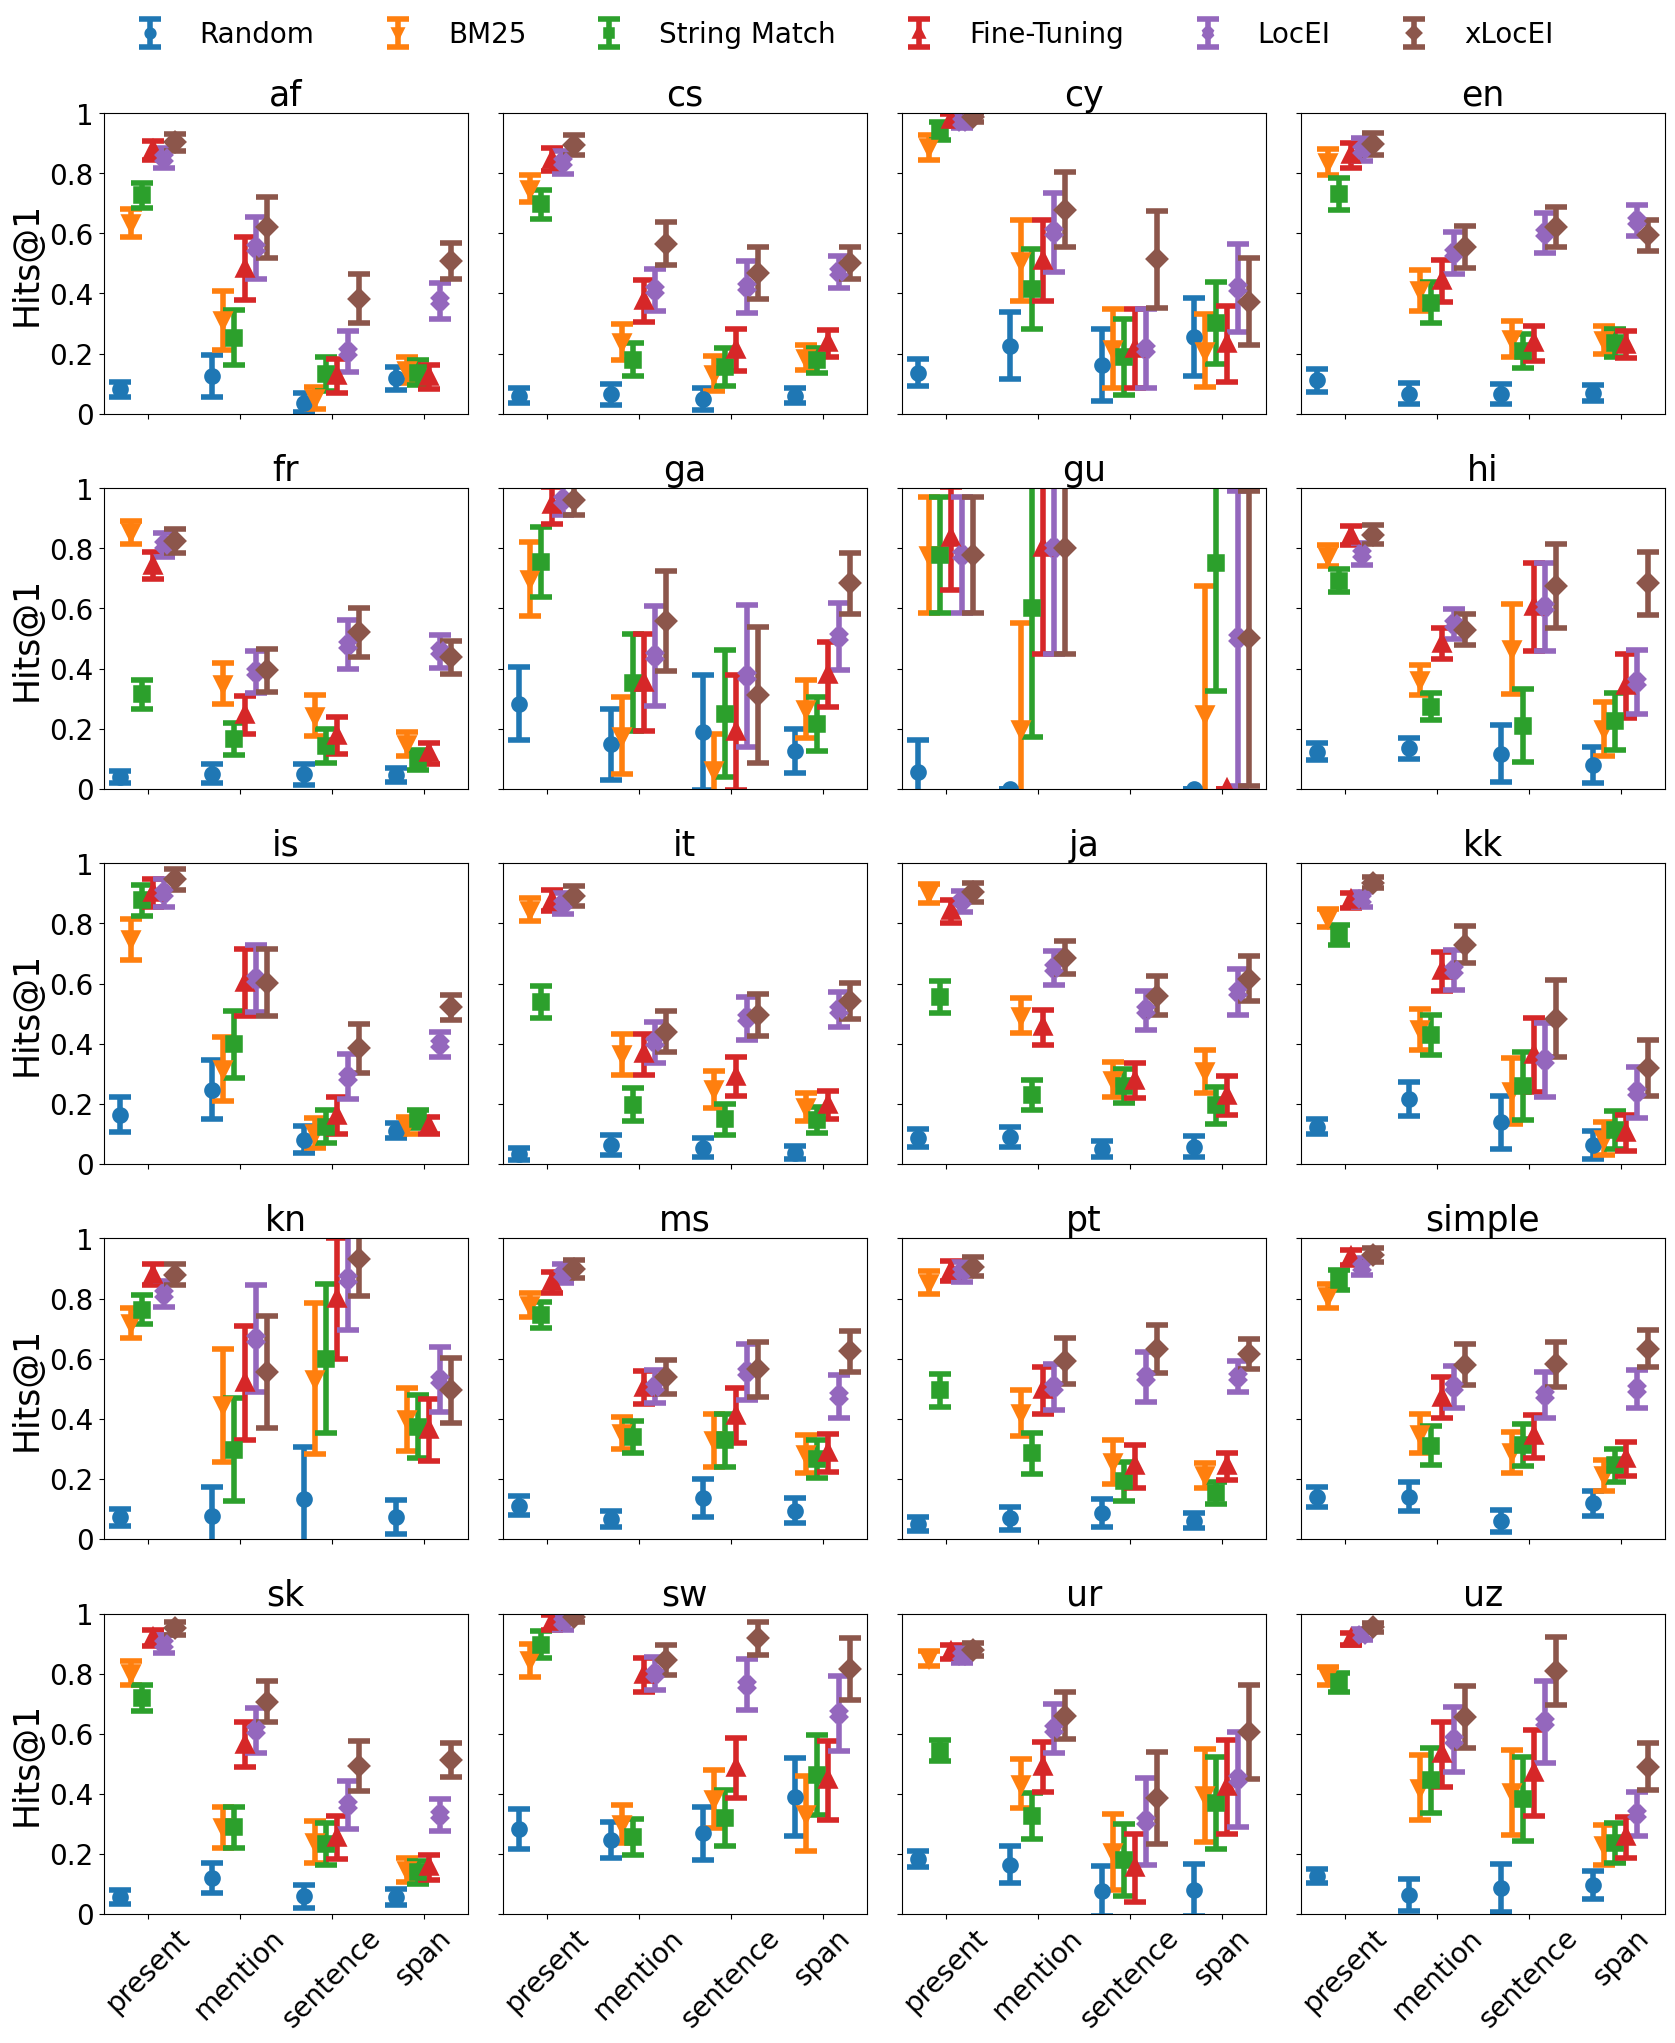

In [26]:
fig, axs = plt.subplots(5, 4, figsize=(17, 20))

langs = sorted(list(dfs.keys()))
for i in range(5):
    for j in range(4):
        lang = langs[i * 4 + j]
        counter = -2.5
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_hits_at_k[lang][column][s]['1']['score'] - stratified_hits_at_k[lang][column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][column][s]['1']['cl'][1] - stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels
                axs[i, j].set_yticklabels([])
                axs[i, j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                # rotate x labels
                counter += 1
        if f'roberta_simple_{lang}' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_simple_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='^', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='Fine-Tuning', color='C3')
            counter += 1
        if f'roberta_full_{lang}' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_full_{lang}'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='LocEI', color='C4')
            counter += 1
        if f'roberta_full_multilingual' in dfs[lang].columns:
            y_points = [stratified_hits_at_k[lang][f'roberta_full_multilingual-all'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual-all'].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[lang][f'roberta_full_multilingual-all'][s]['1']['score'] - stratified_hits_at_k[lang][f'roberta_full_multilingual-all'][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual-all'].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][f'roberta_full_multilingual-all'][s]['1']['cl'][1] - stratified_hits_at_k[lang][f'roberta_full_multilingual-all'][s]['1']['score'] if s in stratified_hits_at_k[lang][f'roberta_full_multilingual-all'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='D', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='xLocEI', color='C5')
            counter += 1

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.5, 1.03), frameon=False, markerscale=0.6)

for i in range(5):
    # set y axis labels
    axs[i, 0].set_ylabel('Hits@1', fontsize=25)
    # set y ticks
    axs[i, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    axs[i, 0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
    
for i in range(4):
    axs[-1, i].set_xticks([0, 1, 2, 3])
    axs[-1, i].set_xticklabels(['present', 'mention', 'sentence', 'span'], fontsize=20)
    # rotate x labels
    axs[-1, i].tick_params(axis='x', rotation=45)
                
plt.tight_layout()
plt.savefig('hits_at_1_full.pdf', bbox_inches='tight')

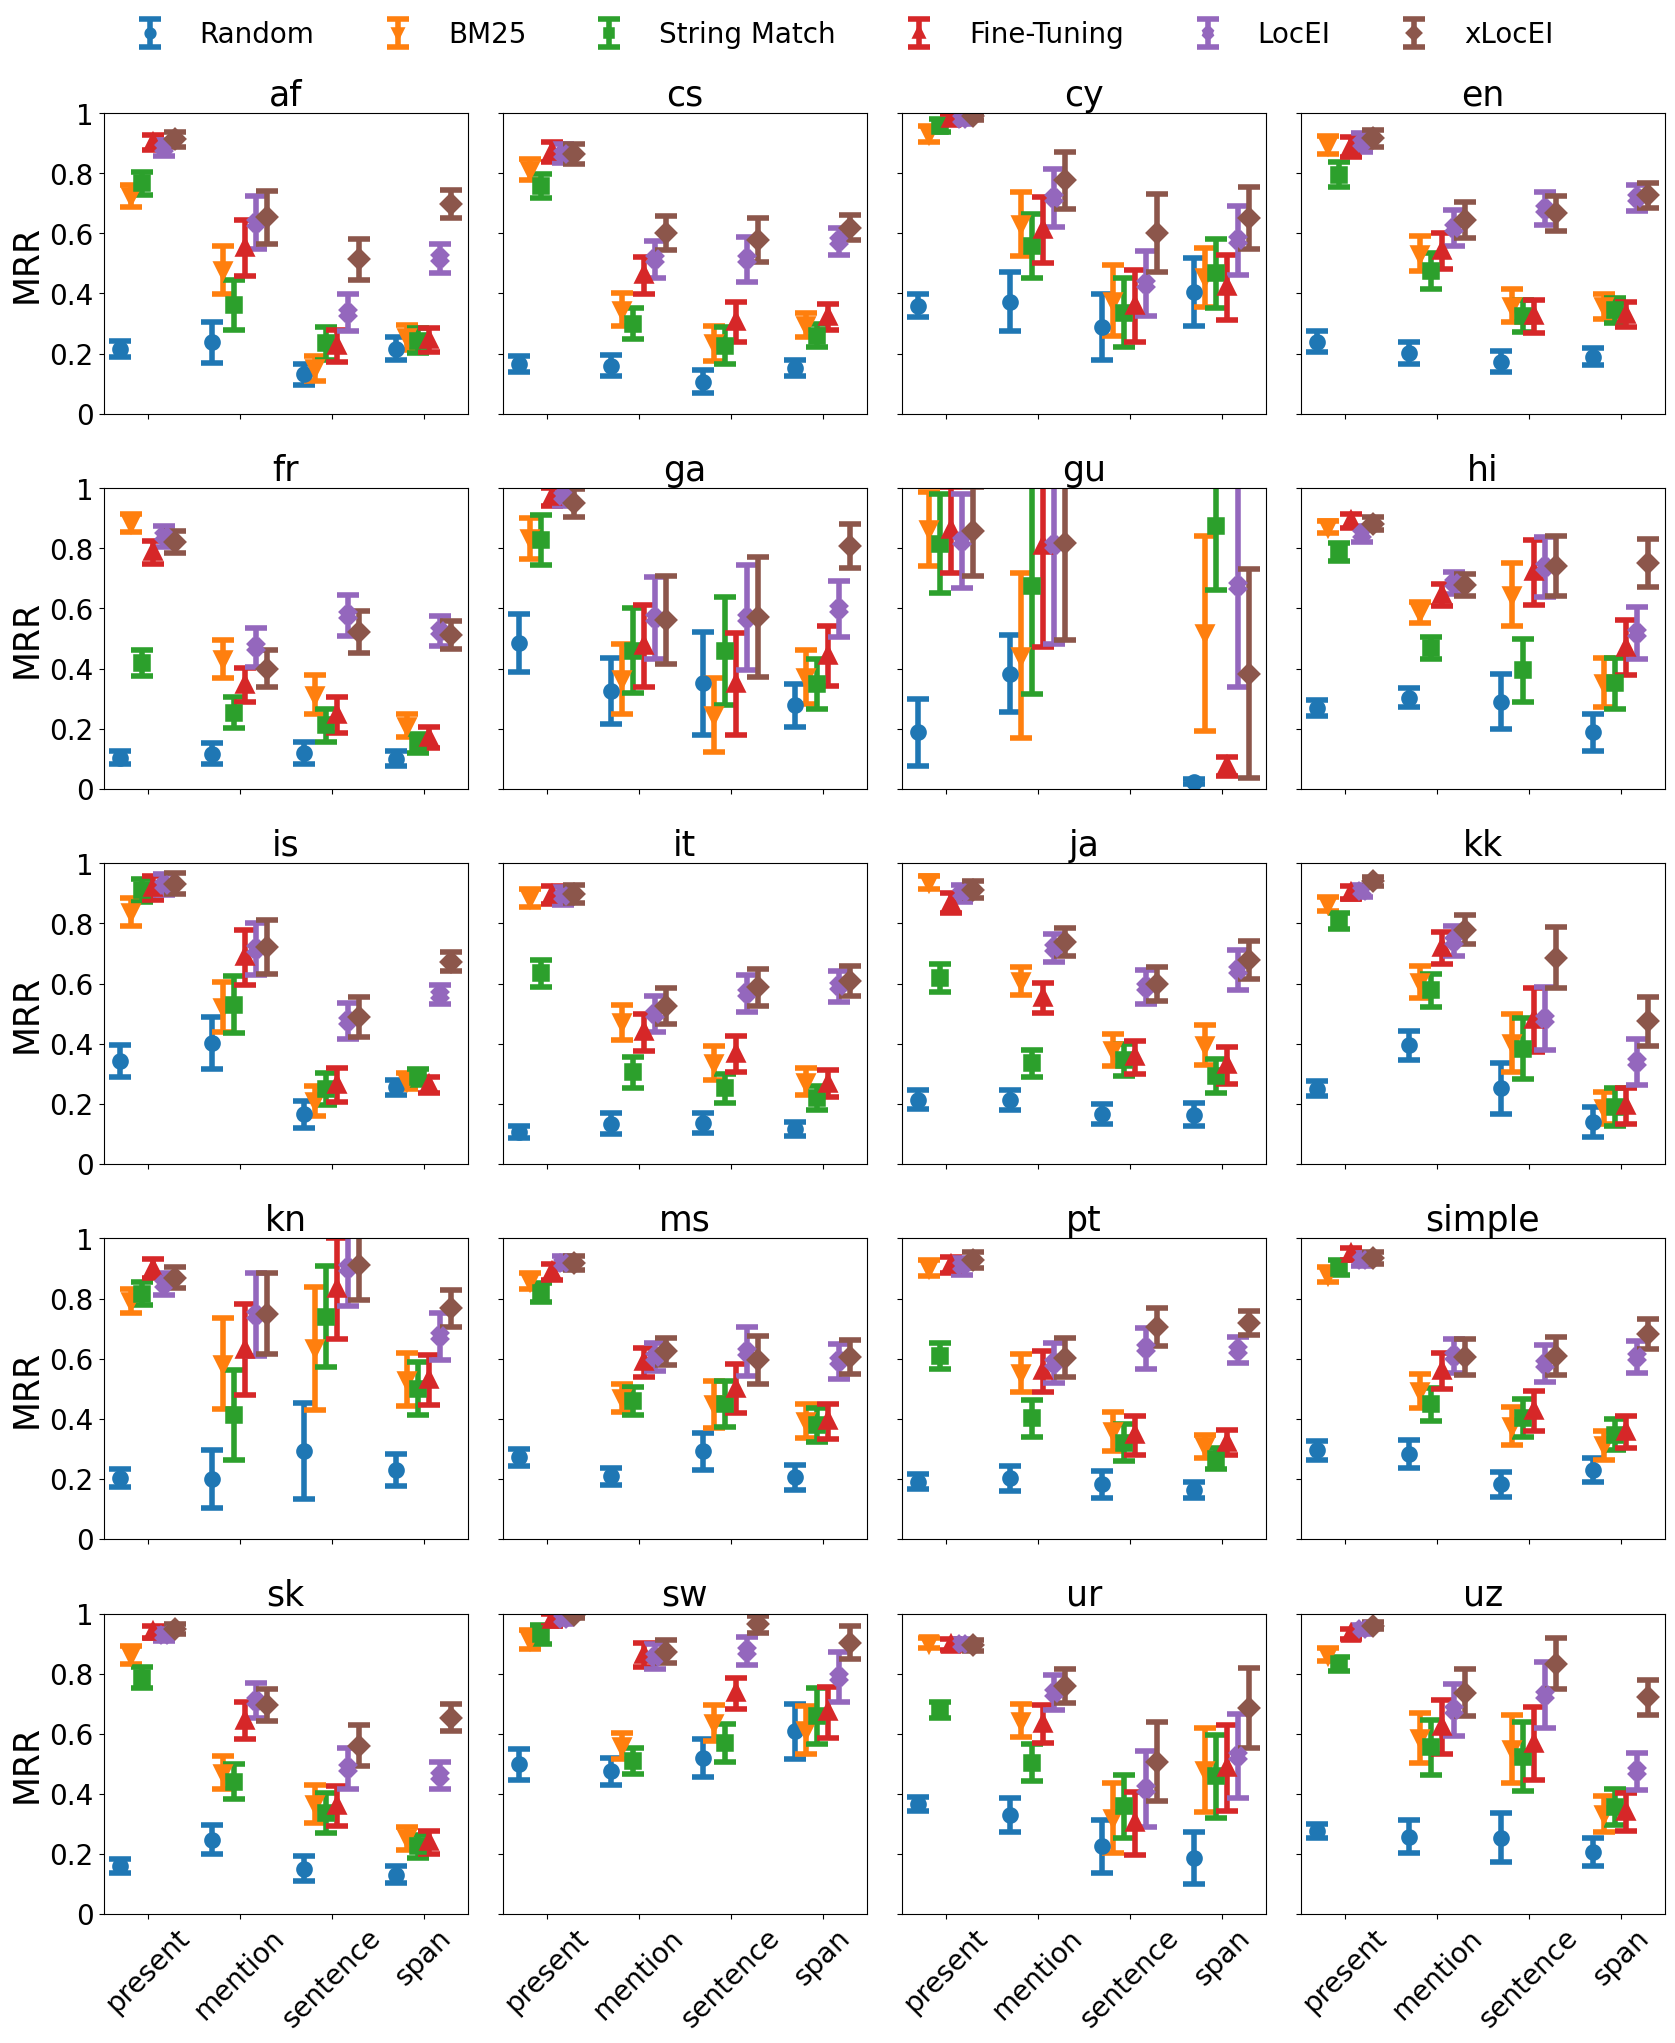

In [27]:
fig, axs = plt.subplots(5, 4, figsize=(17, 20))

langs = sorted(list(dfs.keys()))
for i in range(5):
    for j in range(4):
        lang = langs[i * 4 + j]
        counter = -2.5
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_mrr_at_k[lang][column][s]['max']['score'] - stratified_mrr_at_k[lang][column][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][column][s]['max']['cl'][1] - stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels
                axs[i, j].set_yticklabels([])
                axs[i, j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                # rotate x labels
                counter += 1
        if f'roberta_simple_{lang}' in dfs[lang].columns:
            y_points = [stratified_mrr_at_k[lang][f'roberta_simple_{lang}'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_simple_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_mrr_at_k[lang][f'roberta_simple_{lang}'][s]['max']['score'] - stratified_mrr_at_k[lang][f'roberta_simple_{lang}'][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][f'roberta_simple_{lang}'][s]['max']['cl'][1] - stratified_mrr_at_k[lang][f'roberta_simple_{lang}'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_simple_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='^', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='Fine-Tuning', color='C3')
            counter += 1
        if f'roberta_full_{lang}' in dfs[lang].columns:
            y_points = [stratified_mrr_at_k[lang][f'roberta_full_{lang}'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_full_{lang}'].keys() else -1 for s in strategies]
            y_err = [[stratified_mrr_at_k[lang][f'roberta_full_{lang}'][s]['max']['score'] - stratified_mrr_at_k[lang][f'roberta_full_{lang}'][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][f'roberta_full_{lang}'][s]['max']['cl'][1] - stratified_mrr_at_k[lang][f'roberta_full_{lang}'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_full_{lang}'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='LocEI', color='C4')
            counter += 1
        if f'roberta_full_multilingual' in dfs[lang].columns:
            y_points = [stratified_mrr_at_k[lang][f'roberta_full_multilingual'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_full_multilingual'].keys() else -1 for s in strategies]
            y_err = [[stratified_mrr_at_k[lang][f'roberta_full_multilingual'][s]['max']['score'] - stratified_mrr_at_k[lang][f'roberta_full_multilingual'][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][f'roberta_full_multilingual'].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][f'roberta_full_multilingual'][s]['max']['cl'][1] - stratified_mrr_at_k[lang][f'roberta_full_multilingual'][s]['max']['score'] if s in stratified_mrr_at_k[lang][f'roberta_full_multilingual'].keys() else 0 for s in strategies]]
            axs[i, j].errorbar([s + counter * 0.12 for s in range(len(strategies))], y_points, yerr=y_err, marker='D', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='xLocEI', color='C5')
            counter += 1

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=20, bbox_to_anchor=(0.5, 1.03), frameon=False, markerscale=0.6)

for i in range(5):
    # set y axis labels
    axs[i, 0].set_ylabel('MRR', fontsize=25)
    # set y ticks
    axs[i, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    axs[i, 0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
    
for i in range(4):
    axs[-1, i].set_xticks([0, 1, 2, 3])
    axs[-1, i].set_xticklabels(['present', 'mention', 'sentence', 'span'], fontsize=20)
    # rotate x labels
    axs[-1, i].tick_params(axis='x', rotation=45)
                
plt.tight_layout()
plt.savefig('mrr_full.pdf', bbox_inches='tight')

### Model performance as a function of the language size

In [28]:
# Robin plot

# find the size of each language
sizes = {lang: None for lang in dfs}
for lang in tqdm(dfs):
    # find the number of articles
    sizes[lang] = len(pd.read_parquet(f'/dlabdata1/tsoares/wikidumps/{lang}wiki-NS0-20231001/processed_data/pages'))
print(sizes)

100%|██████████| 20/20 [01:20<00:00,  4.02s/it]

{'ms': 368221, 'sk': 246175, 'pt': 1110520, 'af': 111582, 'cy': 279497, 'kk': 238690, 'fr': 2557936, 'simple': 240247, 'hi': 162972, 'ur': 198553, 'en': 6725328, 'cs': 532663, 'ga': 59127, 'is': 57329, 'kn': 31287, 'gu': 30438, 'ja': 1389246, 'sw': 78522, 'it': 1830602, 'uz': 246634}


ms all 0.653 0.699
ms present 0.8826530612244898 0.8979591836734694
ms missing 0.5049342105263158 0.5707236842105263
sk all 0.603 0.714
sk present 0.8976982097186701 0.9514066496163683
sk missing 0.41379310344827586 0.5615763546798029
pt all 0.65 0.711
pt present 0.8885542168674698 0.9066265060240963
pt missing 0.531437125748503 0.6137724550898204
af all 0.5902547065337763 0.6854928017718716
af present 0.8514150943396226 0.9033018867924528
af missing 0.35908141962421714 0.49269311064718163
cy all 0.7705382436260623 0.8158640226628895
cy present 0.9727272727272728 0.9863636363636363
cy missing 0.43609022556390975 0.5338345864661654
kk all 0.739 0.808
kk present 0.8800623052959502 0.9361370716510904
kk missing 0.4860335195530726 0.5782122905027933
fr all 0.573 0.579
fr present 0.8107344632768362 0.8248587570621468
fr missing 0.44272445820433437 0.44427244582043346
simple all 0.658 0.737
simple present 0.9065656565656566 0.9444444444444444
simple missing 0.49503311258278143 0.600993377483

Text(0, 0.5, '$\\Delta$Hits@1 (LocEI$_{\\text{MULTI}}$ - LocEI$_{\\text{MONO}}$)')

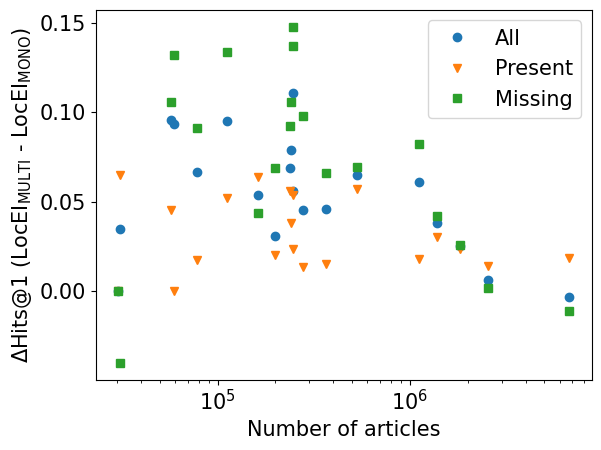

In [29]:
x = []
y = {'all': [], 'present': [], 'missing': []}
for lang in dfs:
    x.append(sizes[lang])
    full_df = dfs[lang]
    df_present = full_df[full_df['missing_category'] == 'present']
    df_missing = full_df[full_df['missing_category'] != 'present']
    for category, df in zip(['all', 'present', 'missing'], [full_df, df_present, df_missing]):
        ranks_mono = df['roberta_full_' + lang].tolist()
        ranks_multi = df['roberta_full_multilingual-all'].tolist()
        
        hits_at_1_mono = np.mean(np.array(ranks_mono) <= 1)
        hits_at_1_multi = np.mean(np.array(ranks_multi) <= 1)
        
        print(lang, category, hits_at_1_mono, hits_at_1_multi)
        
        y[category].append(hits_at_1_multi - hits_at_1_mono)

# sort x and y jointly
_, y['all'] = zip(*sorted(zip(x, y['all'])))
_, y['present'] = zip(*sorted(zip(x, y['present'])))
x, y['missing'] = zip(*sorted(zip(x, y['missing'])))

fig, ax = plt.subplots()
ax.plot(x, y['all'], label='All', linestyle='None', marker='o')
ax.plot(x, y['present'], label='Present', linestyle='None', marker='v')
ax.plot(x, y['missing'], label='Missing', linestyle='None', marker='s')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Number of articles')
ax.set_ylabel('$\Delta$Hits@1 (LocEI$_{\\text{MULTI}}$ - LocEI$_{\\text{MONO}}$)')

### Model performance as a function of the number of candidates

In [30]:
x = {'all': [], 'present': [], 'missing': []}
y = {method: {'all': [], 'present': [], 'missing': []} for method in ['roberta_full_', 'roberta_full_multilingual-all']}
for lang in dfs:
    full_df = dfs[lang]
    df_present = full_df[full_df['missing_category'] == 'present']
    df_missing = full_df[full_df['missing_category'] != 'present']
    for category, df in zip(['all', 'present', 'missing'], [full_df, df_present, df_missing]):
        x[category].append(df['number_candidates'].mean())
        
        ranks = df['roberta_full_' + lang].tolist()
        hits_at_1 = np.mean(np.array(ranks) <= 1)
        y['roberta_full_'][category].append(hits_at_1)
        
        ranks = df['roberta_full_multilingual-all'].tolist()
        hits_at_1 = np.mean(np.array(ranks) <= 1)
        y['roberta_full_multilingual-all'][category].append(hits_at_1)

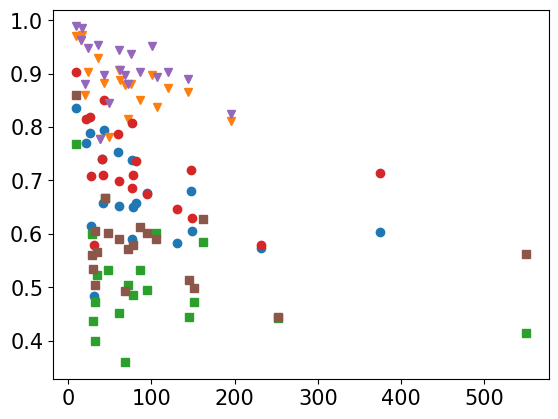

In [31]:
# plot the results
fig, ax = plt.subplots()
for method in ['roberta_full_', 'roberta_full_multilingual-all']:
    # dont plot lines to connect points
    ax.plot(x['all'], y[method]['all'], label=method + ' (All)', linestyle='None', marker='o')
    ax.plot(x['present'], y[method]['present'], label=method + ' (Present)', linestyle='None', marker='v')
    ax.plot(x['missing'], y[method]['missing'], label=method + ' (Missing)', linestyle='None', marker='s')

## Zero-Shot vs Fine-Tuned

In [32]:
columns = ['roberta_full_multilingual-all', 'roberta_full_multilingual']
labels = ['xLocEI$_{20}$', 'xLocEI$_{11}$']
langs = sorted(['fr', 'pt', 'ms', 'sk', 'simple', 'kk', 'af', 'ga', 'gu'])
markers = ['o', 'v']
colours = ['C0', 'C1']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']

In [33]:
difference = {strategy: [0, 0] for strategy in strategies}
for lang in langs:
    for strategy in strategies:
        try:
            difference[strategy][0] += stratified_hits_at_k[lang]['roberta_full_multilingual'][strategy]['1']['score'] / stratified_hits_at_k[lang]['roberta_full_multilingual-all'][strategy]['1']['score']
            difference[strategy][1] += 1
        except:
            pass
for strategy in strategies:
    difference[strategy][0] /= difference[strategy][1]
print(difference)

{'present': [0.9864602439346645, 9], 'missing_mention': [0.8924116532420514, 9], 'missing_sentence': [1.0052895976282235, 8], 'missing_span': [0.9590701160157293, 9]}


In [34]:
difference = {strategy: [0, 0] for strategy in strategies}
for lang in langs:
    for strategy in strategies:
        try:
            difference[strategy][0] += stratified_hits_at_k[lang]['roberta_full_multilingual'][strategy]['1']['score'] / stratified_hits_at_k[lang]['roberta_full_' + lang][strategy]['1']['score']
            difference[strategy][1] += 1
        except:
            pass
for strategy in strategies:
    difference[strategy][0] /= difference[strategy][1]
print(difference)

{'present': [1.0170414490858668, 9], 'missing_mention': [0.9972094966527517, 9], 'missing_sentence': [1.2376253499932584, 8], 'missing_span': [1.224503565397598, 9]}


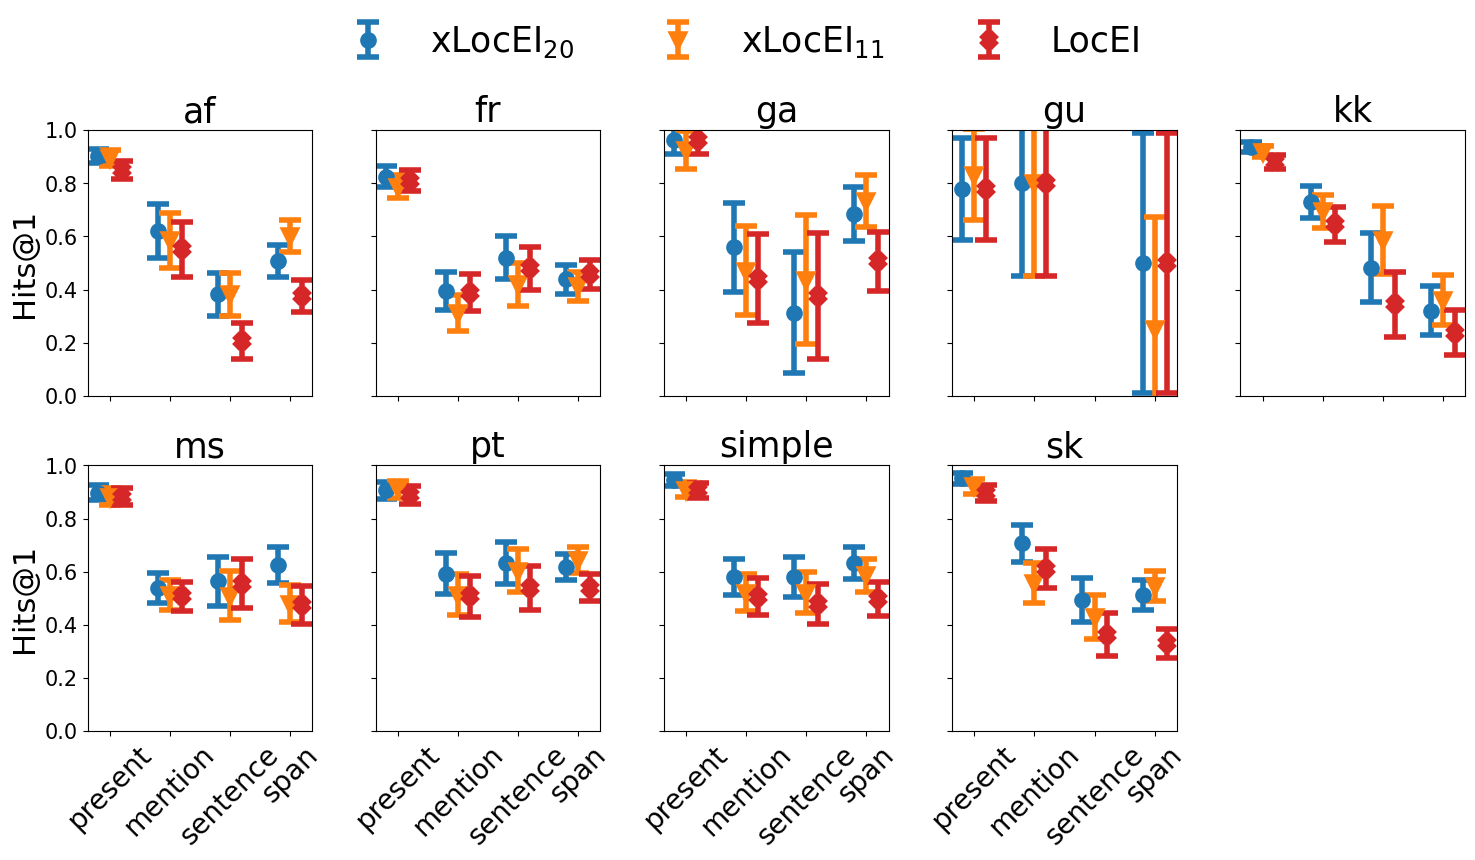

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
# fig.suptitle('Hits@1', fontsize=20, y=1.02, fontweight='bold')

for i in range(2):
    for j in range(5):
        if i * 5 + j >= len(langs):
            break
        lang = langs[i * 5 + j]
        counter = -1
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_hits_at_k[lang][column][s]['1']['score'] - stratified_hits_at_k[lang][column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][column][s]['1']['cl'][1] - stratified_hits_at_k[lang][column][s]['1']['score'] if s in stratified_hits_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels except for the bottom row
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels except for the left column
                if j != 0:
                    axs[i, j].set_yticklabels([])
                else:
                    # set y title to Hits@1
                    axs[i, j].set_ylabel('Hits@1', fontsize=22)
                # rotate x labels
                # axs[i, j].tick_params(axis='x', rotation=30)
                counter += 1
        extra_column = 'roberta_full_' + lang
        y_points = [stratified_hits_at_k[lang][extra_column][s]['1']['score'] if s in stratified_hits_at_k[lang][extra_column].keys() else -1 for s in strategies]
        y_err = [[stratified_hits_at_k[lang][extra_column][s]['1']['score'] - stratified_hits_at_k[lang][extra_column][s]['1']['cl'][0] if s in stratified_hits_at_k[lang][extra_column].keys() else 0 for s in strategies], [stratified_hits_at_k[lang][extra_column][s]['1']['cl'][1] - stratified_hits_at_k[lang][extra_column][s]['1']['score'] if s in stratified_hits_at_k[lang][extra_column].keys() else 0 for s in strategies]]
        axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='LocEI', color='C3')

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=6, fontsize=25, bbox_to_anchor=(0.5, 1.1), frameon=False)

# set the x ticks in the last row to be the strategies
for j in range(5):
    axs[-1, j].set_xticks([0, 1, 2, 3])
    axs[-1, j].set_xticklabels(['present', 'mention', 'sentence', 'span'], fontsize=20)
    # rotate x labels
    axs[-1, j].tick_params(axis='x', rotation=45)
    
# remove the plot from position (-1, -1)
fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.savefig('hits_at_1_zeroshot.pdf', bbox_inches='tight')

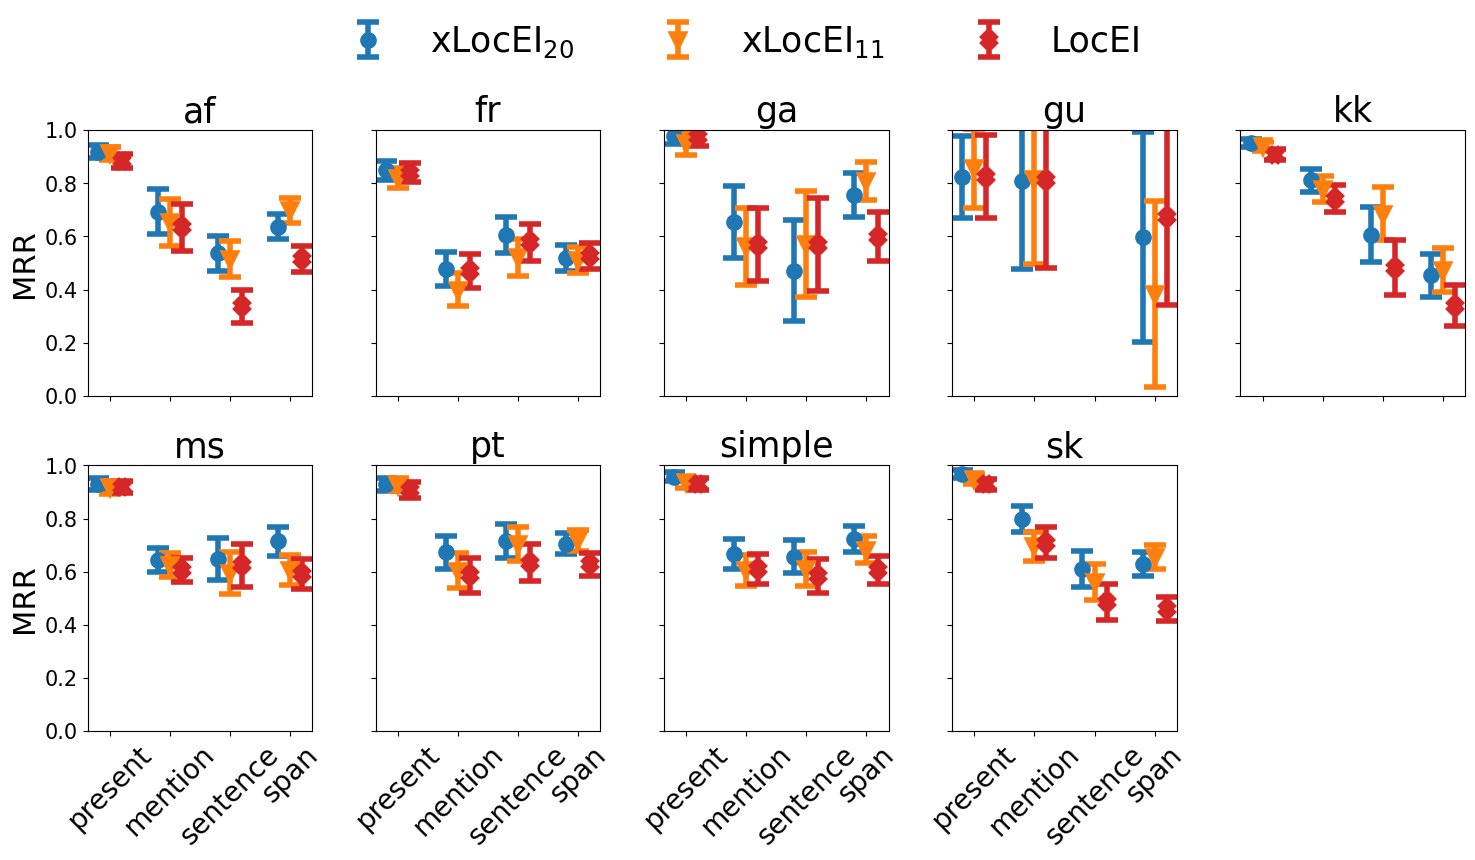

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
# fig.suptitle('Hits@1', fontsize=20, y=1.02, fontweight='bold')

for i in range(2):
    for j in range(5):
        if i * 5 + j >= len(langs):
            break
        lang = langs[i * 5 + j]
        counter = -1
        for column, label, marker, colour in zip(columns, labels, markers, colours):
            if column in dfs[lang].columns:
                # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
                y_points = [stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else -1 for s in strategies]
                y_err = [[stratified_mrr_at_k[lang][column][s]['max']['score'] - stratified_mrr_at_k[lang][column][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][column][s]['max']['cl'][1] - stratified_mrr_at_k[lang][column][s]['max']['score'] if s in stratified_mrr_at_k[lang][column].keys() else 0 for s in strategies]]
                axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, color=colour)
                # set y axis limits (0-1)
                axs[i, j].set_ylim(0, 1)
                # set the title of each subplot to the language
                axs[i, j].set_title(lang, fontsize=25)
                # remove the x labels except for the bottom row
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([0, 1, 2, 3])
                # remove the y labels except for the left column
                if j != 0:
                    axs[i, j].set_yticklabels([])
                else:
                    # set y title to Hits@1
                    axs[i, j].set_ylabel('MRR', fontsize=22)
                # rotate x labels
                # axs[i, j].tick_params(axis='x', rotation=30)
                counter += 1
        extra_column = 'roberta_full_' + lang
        y_points = [stratified_mrr_at_k[lang][extra_column][s]['max']['score'] if s in stratified_mrr_at_k[lang][extra_column].keys() else -1 for s in strategies]
        y_err = [[stratified_mrr_at_k[lang][extra_column][s]['max']['score'] - stratified_mrr_at_k[lang][extra_column][s]['max']['cl'][0] if s in stratified_mrr_at_k[lang][extra_column].keys() else 0 for s in strategies], [stratified_mrr_at_k[lang][extra_column][s]['max']['cl'][1] - stratified_mrr_at_k[lang][extra_column][s]['max']['score'] if s in stratified_mrr_at_k[lang][extra_column].keys() else 0 for s in strategies]]
        axs[i, j].errorbar([0 + counter * 0.2, 1 + counter * 0.2, 2 + counter * 0.2, 3 + counter * 0.2], y_points, yerr=y_err, marker='X', capsize=8, markersize=8, linestyle='None', elinewidth=4, markeredgewidth=4, label='LocEI', color='C3')

# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=6, fontsize=25, bbox_to_anchor=(0.5, 1.1), frameon=False)

# set the x ticks in the last row to be the strategies
for j in range(5):
    axs[-1, j].set_xticks([0, 1, 2, 3])
    axs[-1, j].set_xticklabels(['present', 'mention', 'sentence', 'span'], fontsize=20)
    # rotate x labels
    axs[-1, j].tick_params(axis='x', rotation=45)
    
    
# remove the plot from position (-1, -1)
fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.savefig('mrr_zeroshot.pdf', bbox_inches='tight')

# Plot Ablations

## Impact of each modification to training

In [37]:
langs = ['kn', 'uz', 'cs', 'en']
strategies = ['present', 'missing_mention', 'missing_sentence', 'missing_span']
# columns = ['roberta_simple_rank', 'roberta_two_stage_v2_rank', 'roberta_mask_v2_rank', 'roberta_section_v2_rank', 'roberta_mention_v2_rank']
# columns = ['roberta_simple_rank', 'roberta_mask_rank', 'roberta_section_rank', 'roberta_mention_rank', 'roberta_two_stage_rank']
columns = ['roberta_simple_rank', 'roberta_mask_final_multilingual_rank', 'roberta_two_stage_final_multilingual_rank', 'roberta_mention_final_multilingual_rank']
labels = ['(1): LM Fine-Tuning', '(2): (1) + Data Augmentation', '(3): (2) + Second Stage', '(4): (3) + Knowledge Injection']
# labels = ['(1): LM Fine-Tuning', '(2): (1) + Data Augmentation', '(3): (2) + Section Knowledge', '(4): (3) + Mention Knowledge', '(5): (4) + Second Stage']
markers = ['o', 'v', 's', 'D', 'X']
colours = ['C0', 'C1', 'C2', 'C3', 'C4']

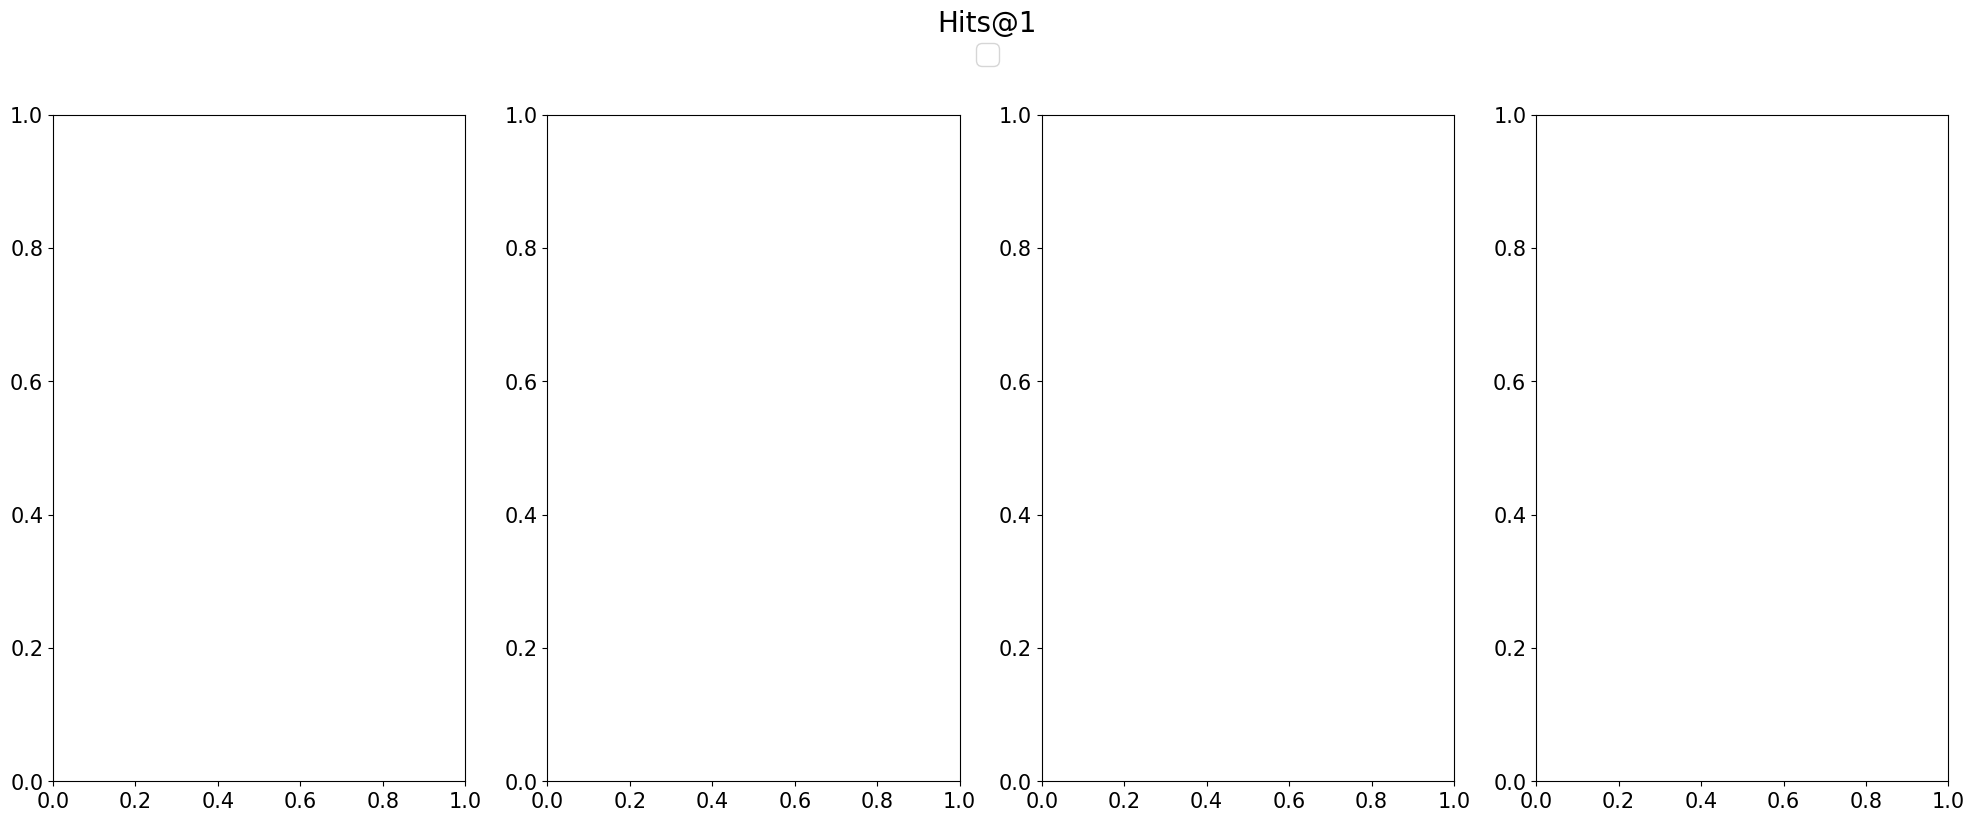

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_multilingual'
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [39]:
for lang in langs:
    print("\\multirow{5}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_multilingual'
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(f" & {hits_at_k[lang][column]['1']['score']:.3f} & {mrr_at_k[lang][column]['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')

\multirow{5}{*}{kn} & (1)

KeyError: 'roberta_simple_rank_multilingual'

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    for i, column_1 in enumerate(columns):
        column_1 += '_multilingual'
        for column_2 in columns[i+1:i+2]:
            column_2 += '_multilingual'
            for strategy in strategies:
                ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
                ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
                
                hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
                hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
                
                mrr_1 = [1 / rank for rank in ranks_1]
                mrr_2 = [1 / rank for rank in ranks_2]
                
                # compute the p-values
                print(f"{column_1} vs {column_2} for {strategy}")
                print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
                print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
                
            ranks_1_missing = missing_df[column_1].tolist()
            ranks_2_missing = missing_df[column_2].tolist()
            
            hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
            hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
            
            mrr_1_missing = [1 / rank for rank in ranks_1_missing]
            mrr_2_missing = [1 / rank for rank in ranks_2_missing]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for missing")
            print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
            
            ranks_1 = test_df[column_1].tolist()
            ranks_2 = test_df[column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for all")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
            

kn
roberta_simple_rank_multilingual vs roberta_mask_final_multilingual_rank_multilingual for present
	MRR@max: TtestResult(statistic=1.1940495984260302, pvalue=0.8835401681496331, df=614.0)
	Hits@1: TtestResult(statistic=1.260194205711129, pvalue=0.895960978867351, df=614.0)
roberta_simple_rank_multilingual vs roberta_mask_final_multilingual_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=-0.12422614854507717, pvalue=0.4508075946222466, df=52.0)
	Hits@1: TtestResult(statistic=0.0, pvalue=0.5, df=52.0)
roberta_simple_rank_multilingual vs roberta_mask_final_multilingual_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=-0.12732265351110658, pvalue=0.44979751579753113, df=28.0)
	Hits@1: TtestResult(statistic=0.0, pvalue=0.5, df=28.0)
roberta_simple_rank_multilingual vs roberta_mask_final_multilingual_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=-0.9989557233987779, pvalue=0.15964389132318013, df=164.0)
	Hits@1: TtestResult(s

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[1] + '_multilingual'
    for column_2 in [columns[0]] + columns[2:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        
        ranks_1 = test_df[column_1].tolist()
        ranks_2 = test_df[column_2].tolist()
        
        hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
        hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
        
        mrr_1 = [1 / rank for rank in ranks_1]
        mrr_2 = [1 / rank for rank in ranks_2]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for all")
        print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        

kn
roberta_mask_final_multilingual_rank_multilingual vs roberta_simple_rank_multilingual for present
	MRR@max: TtestResult(statistic=-1.1940495984260302, pvalue=0.11645983185036692, df=614.0)
	Hits@1: TtestResult(statistic=-1.260194205711129, pvalue=0.10403902113264896, df=614.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_simple_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=0.12422614854507717, pvalue=0.5491924053777534, df=52.0)
	Hits@1: TtestResult(statistic=0.0, pvalue=0.5, df=52.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_simple_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=0.12732265351110658, pvalue=0.5502024842024689, df=28.0)
	Hits@1: TtestResult(statistic=0.0, pvalue=0.5, df=28.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_simple_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=0.9989557233987779, pvalue=0.8403561086768199, df=164.0)
	Hits@1: TtestResult(s

	MRR@max: TtestResult(statistic=1.0362417161915676, pvalue=0.8498691534117857, df=1454.0)
	Hits@1: TtestResult(statistic=0.9151323136275643, pvalue=0.8198630443450106, df=1454.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_simple_rank_multilingual for all
	MRR@max: TtestResult(statistic=0.5863001084050244, pvalue=0.7211299568824859, df=1998.0)
	Hits@1: TtestResult(statistic=0.44935618161143887, pvalue=0.6733882629469985, df=1998.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_two_stage_final_multilingual_rank_multilingual for present
	MRR@max: TtestResult(statistic=-1.9132855770631254, pvalue=0.028119022703753153, df=542.0)
	Hits@1: TtestResult(statistic=-1.8894903804383854, pvalue=0.029679801782985685, df=542.0)
roberta_mask_final_multilingual_rank_multilingual vs roberta_two_stage_final_multilingual_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=-2.499680912391457, pvalue=0.006421337025337455, df=388.0)
	Hits@1: TtestResult(stat

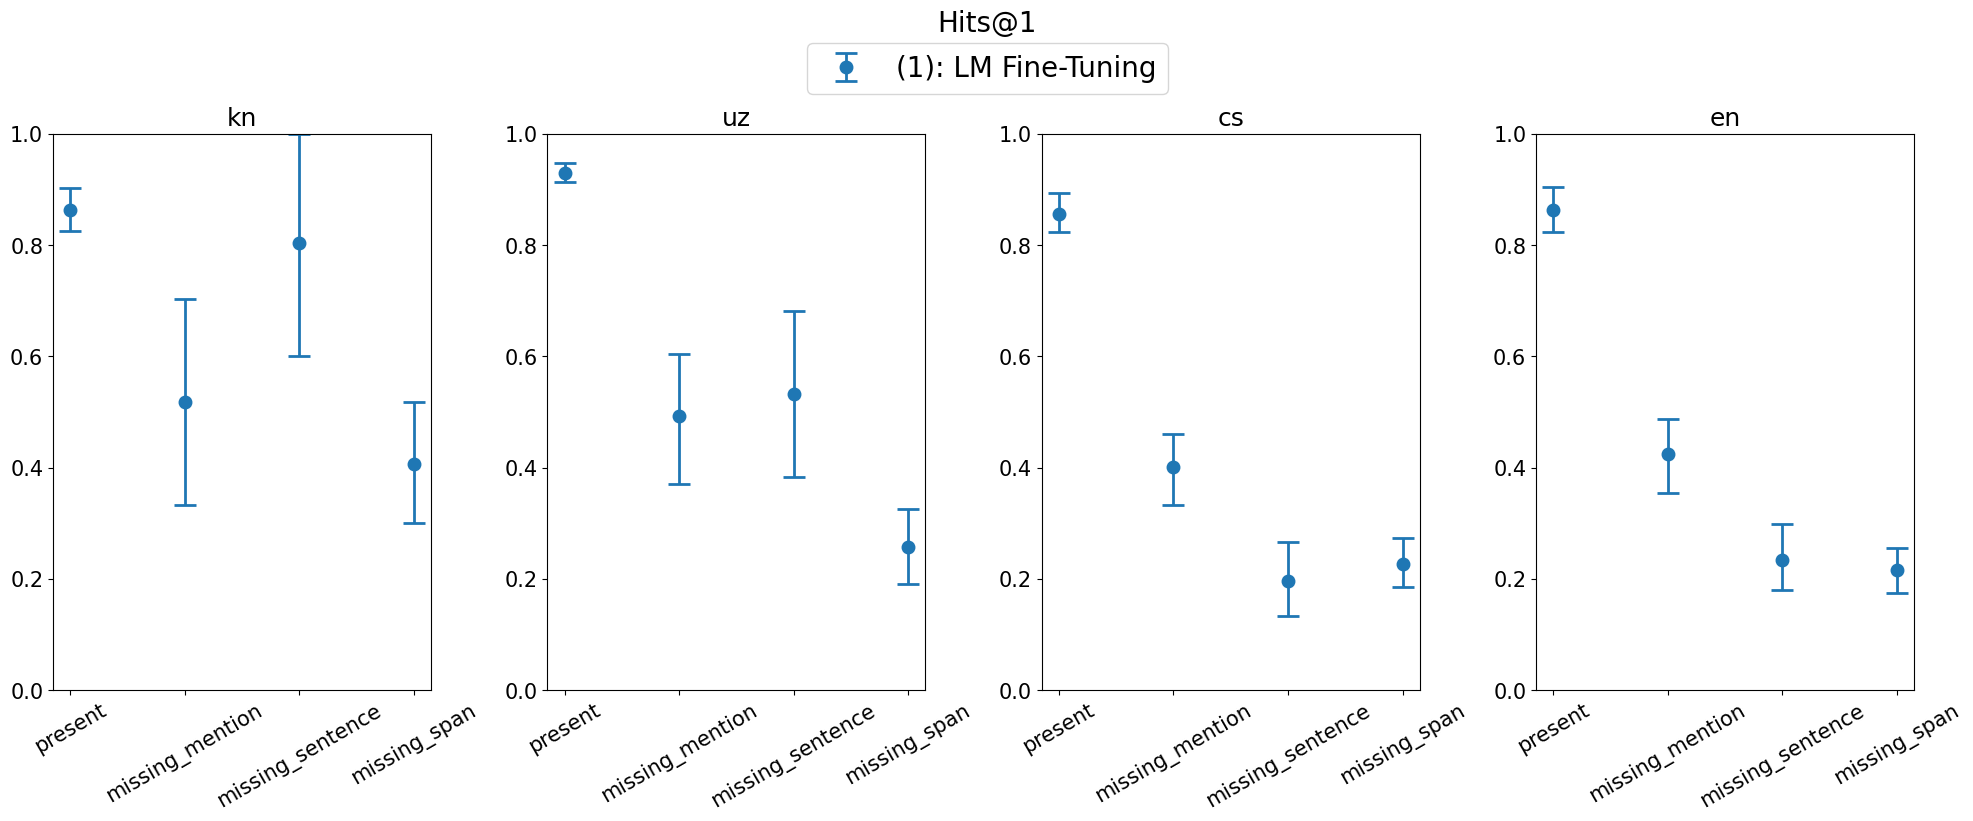

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_' + langs[i]
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

## Impact of each training stage

In [ ]:
langs = ['kn', 'uz', 'cs', 'en']
columns = ['roberta_simple_rank', 'roberta_only_stage_two_rank', 'roberta_two_stage_no_corrupt_rank', 'roberta_two_stage_rank']
labels = ['Only Stage 1', 'Only Stage 2', 'Stage 1 (No Corrupt) + Stage 2', 'Stage 1 + Stage 2']
markers = ['o', 'v', 's', 'D']
colours = ['C0', 'C1', 'C2', 'C3']

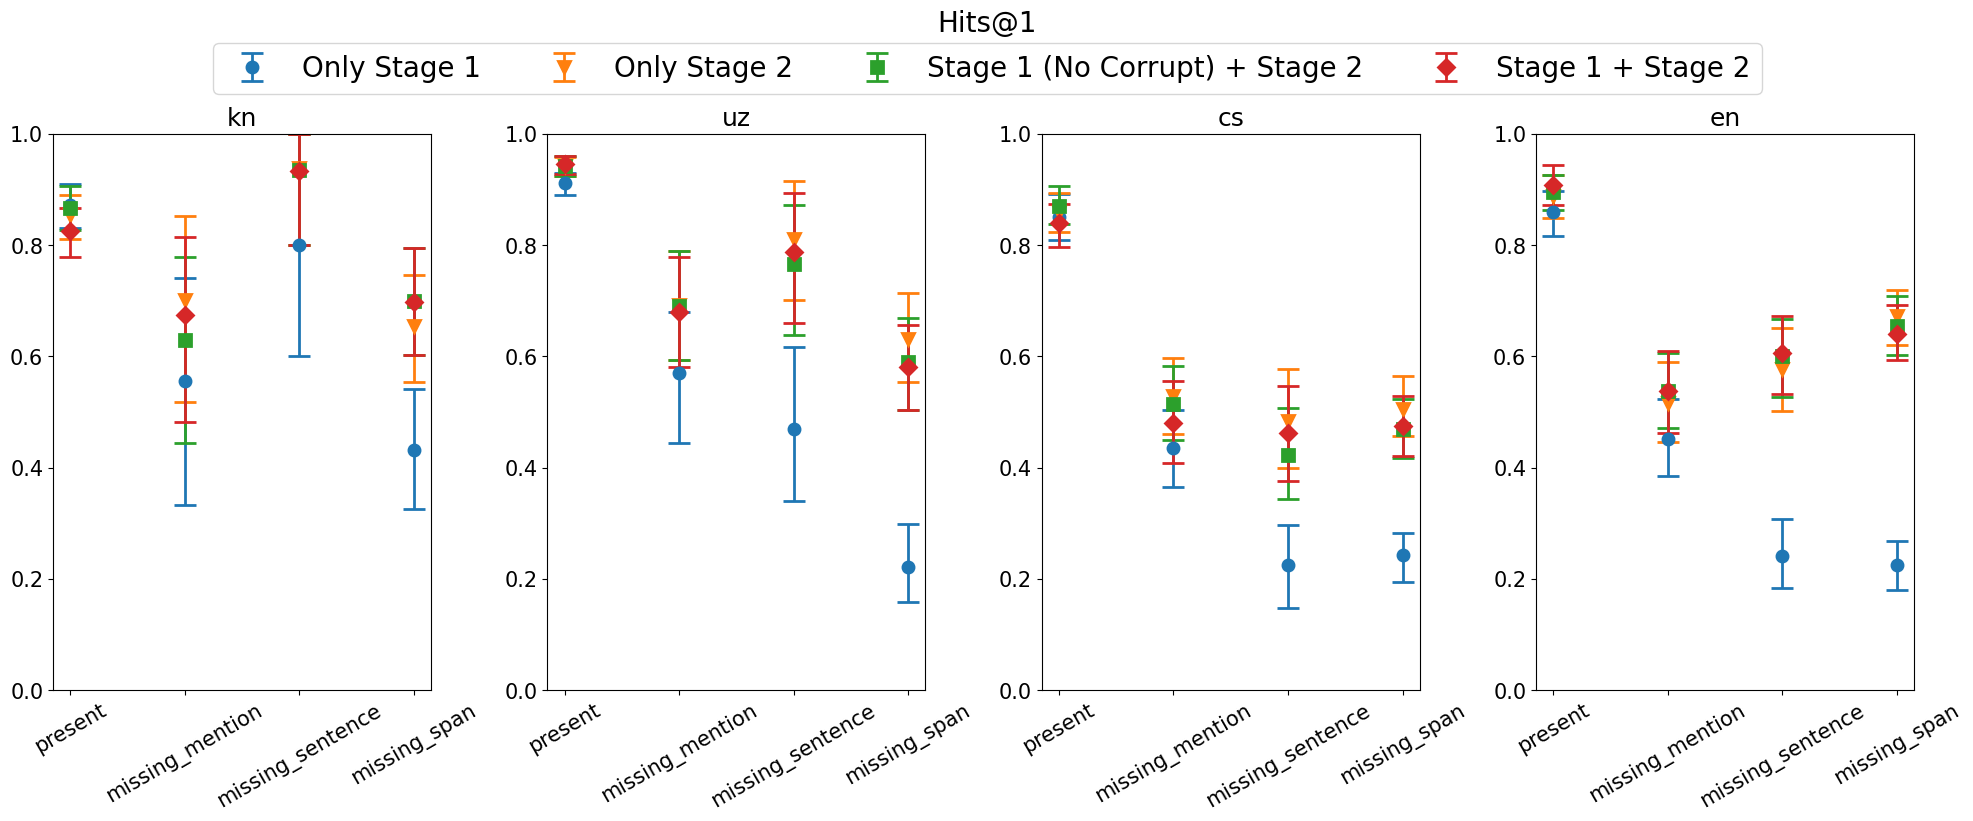

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns, labels, markers, colours):
        column = column + '_' + 'multilingual'
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=8, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [ ]:
for lang in langs:
    print("\\multirow{4}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_multilingual'
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(f" & {hits_at_k[lang][column]['1']['score']:.3f} & {mrr_at_k[lang][column]['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')

\multirow{4}{*}{kn} & (1) & 0.872 & 0.891 & 0.555 & 0.643 & 0.801 & 0.839 & 0.431 & 0.571 & 0.506 & 0.617 & 0.767 & 0.812 \\
 & (2) & 0.854 & 0.878 & 0.702 & 0.758 & 0.938 & 0.949 & 0.654 & 0.813 & 0.695 & 0.817 & 0.808 & 0.860 \\
 & (3) & 0.867 & 0.891 & 0.630 & 0.729 & 0.935 & 0.965 & 0.700 & 0.823 & 0.715 & 0.820 & 0.821 & 0.870 \\
 & (4) & 0.825 & 0.860 & 0.674 & 0.751 & 0.933 & 0.953 & 0.698 & 0.837 & 0.716 & 0.835 & 0.794 & 0.853 \\\hline
\multirow{4}{*}{uz} & (1) & 0.912 & 0.933 & 0.570 & 0.671 & 0.469 & 0.569 & 0.222 & 0.332 & 0.359 & 0.469 & 0.754 & 0.801 \\
 & (2) & 0.942 & 0.958 & 0.692 & 0.771 & 0.811 & 0.849 & 0.631 & 0.734 & 0.675 & 0.764 & 0.867 & 0.902 \\
 & (3) & 0.942 & 0.957 & 0.690 & 0.771 & 0.766 & 0.819 & 0.590 & 0.705

 & 0.646 & 0.745 & 0.859 & 0.897 \\
 & (4) & 0.945 & 0.957 & 0.680 & 0.748 & 0.787 & 0.839 & 0.580 & 0.715 & 0.642 & 0.746 & 0.858 & 0.897 \\\hline
\multirow{4}{*}{cs} & (1) & 0.851 & 0.879 & 0.435 & 0.523 & 0.225 & 0.308 & 0.242 & 0.312 & 0.294 & 0.373 & 0.489 & 0.550 \\
 & (2) & 0.860 & 0.884 & 0.528 & 0.624 & 0.484 & 0.590 & 0.505 & 0.619 & 0.508 & 0.615 & 0.631 & 0.707 \\
 & (3) & 0.871 & 0.898 & 0.514 & 0.624 & 0.423 & 0.550 & 0.470 & 0.593 & 0.473 & 0.594 & 0.614 & 0.699 \\
 & (4) & 0.839 & 0.874 & 0.480 & 0.599 & 0.462 & 0.557 & 0.475 & 0.607 & 0.475 & 0.594 & 0.601 & 0.693 \\\hline
\multirow{4}{*}{en} & (1) & 0.859 & 0.886 & 0.452 & 0.536 & 0.241 & 0.338 & 0.224 & 0.333 & 0.288 & 0.389 & 0.444 & 0.524 \\
 & (2) & 0.889 & 0.910 & 0.517 & 0.603 & 0.578 & 0.669 & 0.672 & 0.742 & 0.605 & 0.684 & 0.683 & 0.745 \\
 & (3) & 0.896 & 0.924 & 0.538 & 0.619 & 0.601 & 0.678 & 0.654 & 0.741 & 0.610 & 0.693 & 0.689 & 0.755 \\
 & (4) & 0.908 & 0.927 & 0.537 & 0.627 & 0.606 & 0.687 & 0.640 & 0

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[0] + '_multilingual'
    for column_2 in columns[1:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        
        ranks_1 = test_df[column_1].tolist()
        ranks_2 = test_df[column_2].tolist()
        
        hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
        hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
        
        mrr_1 = [1 / rank for rank in ranks_1]
        mrr_2 = [1 / rank for rank in ranks_2]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for all")
        print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")

kn
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for present
	MRR@max: TtestResult(statistic=0.5273331572790005, pvalue=0.7009236318191043, df=614.0)
	Hits@1: TtestResult(statistic=0.7035824175040944, pvalue=0.7590202104629835, df=614.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=-1.0497482245123189, pvalue=0.1493441468042502, df=52.0)
	Hits@1: TtestResult(statistic=-1.1193802071650056, pvalue=0.13406099624231832, df=52.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=-1.056926480803706, pvalue=0.149789625659075, df=28.0)
	Hits@1: TtestResult(statistic=-1.0583005244258359, pvalue=0.1494817575272936, df=28.0)
roberta_simple_rank_multilingual vs roberta_only_stage_two_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=-4.656513360731732, pvalue=3.304205528671321e-06, df=164.

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[1] + '_multilingual'
    for column_2 in [columns[0]] + columns[2:]:
        column_2 += '_multilingual'
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        
        ranks_1 = test_df[column_1].tolist()
        ranks_2 = test_df[column_2].tolist()
        
        hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
        hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
        
        mrr_1 = [1 / rank for rank in ranks_1]
        mrr_2 = [1 / rank for rank in ranks_2]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for all")
        print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")

kn
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for present
	MRR@max: TtestResult(statistic=-0.5273331572790005, pvalue=0.29907636818089567, df=614.0)
	Hits@1: TtestResult(statistic=-0.7035824175040944, pvalue=0.24097978953701654, df=614.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_mention
	MRR@max: TtestResult(statistic=1.0497482245123189, pvalue=0.8506558531957498, df=52.0)
	Hits@1: TtestResult(statistic=1.1193802071650056, pvalue=0.8659390037576817, df=52.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_sentence
	MRR@max: TtestResult(statistic=1.056926480803706, pvalue=0.8502103743409251, df=28.0)
	Hits@1: TtestResult(statistic=1.0583005244258359, pvalue=0.8505182424727065, df=28.0)
roberta_only_stage_two_rank_multilingual vs roberta_simple_rank_multilingual for missing_span
	MRR@max: TtestResult(statistic=4.656513360731732, pvalue=0.9999966957944714, df=164.0)
	

In [ ]:
for lang in langs:
    print("\\multirow{4}{*}{" + lang + "} &", end='')
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    for i, column in enumerate(columns):
        column = column + '_' + lang
        if i != 0:
            print('\n &', end='')
        print(f" ({i + 1})", end='')
        for strategy in strategies:
            print(f" & {stratified_hits_at_k[lang][column][strategy]['1']['score']:.3f} & {stratified_mrr_at_k[lang][column][strategy]['max']['score']:.3f}", end='')
            # print score and confidence interval for each strategy for each column
            # print(f"{column} {strategy} {lang} MRR@max: {stratified_mrr_at_k[lang][column][strategy]['max']['score']} {stratified_mrr_at_k[lang][column][strategy]['max']['cl']}")
            # print(f"{column} {strategy} {lang} Hits@1: {stratified_hits_at_k[lang][column][strategy]['1']['score']} {stratified_hits_at_k[lang][column][strategy]['1']['cl']}")
        average_hits_at_k_missing = compute_hits(missing_df[column].tolist())
        average_mrr_at_k_missing = compute_mrr(missing_df[column].tolist())
        print(f" & {average_hits_at_k_missing['1']['score']:.3f} & {average_mrr_at_k_missing['max']['score']:.3f}", end='')
        print(f" & {hits_at_k[lang][column]['1']['score']:.3f} & {mrr_at_k[lang][column]['max']['score']:.3f}", end='')
        print(' \\\\', end='')
    print('\\hline')


\multirow{4}{*}{kn} & (1) & 0.863 & 0.885 & 0.518 & 0.622 & 0.803 & 0.872 & 0.406 & 0.554 & 0.480 & 0.605 & 0.753 & 0.803 \\
 & (2) & 0.283 & 0.402 & 0.374 & 0.510 & 0.345 & 0.462 & 0.288 & 0.516 & 0.313 & 0.506 & 0.290 & 0.434 \\
 & (3) & 0.855 & 0.874 & 0.628 & 0.713 & 0.869 & 0.897 & 0.577 & 0.729 & 0.625 & 0.749 & 0.787 & 0.838 \\
 & (4) & 0.809 & 0.841 & 0.595 & 0.671 & 0.932 & 0.943 & 0.496 & 0.656 & 0.568 & 0.694 & 0.742 & 0.800 \\\hline
\multirow{4}{*}{uz} & (1) & 0.930 & 0.944 & 0.493 & 0.618 & 0.532 & 0.595 & 0.258 & 0.351 & 0.368 & 0.469 & 0.770 & 0.809 \\
 & (2) & 0.902 & 0.929 & 0.617 & 0.704 & 0.550 & 0.653 & 0.369 & 0.482 & 0.469 & 0.575 & 0.779 & 0.828 \\
 & (3) & 0.922 & 0.942 & 0.603 & 0.701 & 0.640 & 0.728 & 0.408 & 0.545 & 0.501 & 0.618 & 0.803 & 0.850 \\
 & (4) & 0.923 & 0.941 & 0.642 & 0.722 & 0.612 & 0.701 & 0.319 & 0.451 & 0.459 & 0.570 & 0.792 & 0.837 \\\hline
\multirow{4}{*}{cs} & (1) & 0.856 & 0.874 & 0.401 & 0.489 & 0.196 & 0.297 & 0.227 & 0.320 & 0.271 & 0.

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[0] + '_' + lang
    for column_2 in columns[1:]:
        column_2 += '_' + lang
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        
        ranks_1 = test_df[column_1].tolist()
        ranks_2 = test_df[column_2].tolist()
        
        hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
        hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
        
        mrr_1 = [1 / rank for rank in ranks_1]
        mrr_2 = [1 / rank for rank in ranks_2]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for all")
        print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")

kn
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for present
	MRR@max: TtestResult(statistic=16.953832977961156, pvalue=1.0, df=614.0)
	Hits@1: TtestResult(statistic=17.988401400720758, pvalue=1.0, df=614.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_mention
	MRR@max: TtestResult(statistic=1.0379973351413947, pvalue=0.8479629785399483, df=52.0)
	Hits@1: TtestResult(statistic=1.087114613009218, pvalue=0.8590001685949769, df=52.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_sentence
	MRR@max: TtestResult(statistic=3.267906270422886, pvalue=0.9985670987550617, df=28.0)
	Hits@1: TtestResult(statistic=2.8243130467507513, pvalue=0.9956832847571615, df=28.0)
roberta_simple_rank_kn vs roberta_only_stage_two_rank_kn for missing_span
	MRR@max: TtestResult(statistic=0.663878103323228, pvalue=0.7461497231539638, df=164.0)
	Hits@1: TtestResult(statistic=1.6311376378192943, pvalue=0.9476099192893115, df=164.0)
roberta_simple_rank_kn vs ro

In [ ]:
from scipy.stats import ttest_ind
for lang in langs:
    print(lang)
    test_df = dfs[lang]
    missing_df = dfs[lang][dfs[lang]['missing_category'] != 'present']
    # compute pair-wise p-values for each strategy
    column_1 = columns[1] + '_' + lang
    for column_2 in [columns[0]] + columns[2:]:
        column_2 += '_' + lang
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")
        
        ranks_1_missing = missing_df[column_1].tolist()
        ranks_2_missing = missing_df[column_2].tolist()
        
        hits_at_1_1_missing = [1 if rank <= 1 else 0 for rank in ranks_1_missing]
        hits_at_1_2_missing = [1 if rank <= 1 else 0 for rank in ranks_2_missing]
        
        mrr_1_missing = [1 / rank for rank in ranks_1_missing]
        mrr_2_missing = [1 / rank for rank in ranks_2_missing]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for missing")
        print(f"\tMRR@max: {ttest_ind(mrr_1_missing, mrr_2_missing, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1_missing, hits_at_1_2_missing, alternative='less')}")
        
        ranks_1 = test_df[column_1].tolist()
        ranks_2 = test_df[column_2].tolist()
        
        hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
        hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
        
        mrr_1 = [1 / rank for rank in ranks_1]
        mrr_2 = [1 / rank for rank in ranks_2]
        
        # compute the p-values
        print(f"{column_1} vs {column_2} for all")
        print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2, alternative='less')}")
        print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2, alternative='less')}")

kn
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for present
	MRR@max: TtestResult(statistic=-16.953832977961156, pvalue=1.8053248965330036e-53, df=614.0)
	Hits@1: TtestResult(statistic=-17.988401400720758, pvalue=9.933383248631753e-59, df=614.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_mention
	MRR@max: TtestResult(statistic=-1.0379973351413947, pvalue=0.15203702146005166, df=52.0)
	Hits@1: TtestResult(statistic=-1.087114613009218, pvalue=0.1409998314050231, df=52.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_sentence
	MRR@max: TtestResult(statistic=-3.267906270422886, pvalue=0.0014329012449383633, df=28.0)
	Hits@1: TtestResult(statistic=-2.8243130467507513, pvalue=0.004316715242838458, df=28.0)
roberta_only_stage_two_rank_kn vs roberta_simple_rank_kn for missing_span
	MRR@max: TtestResult(statistic=-0.663878103323228, pvalue=0.2538502768460362, df=164.0)
	Hits@1: TtestResult(statistic=-1.6311376378192943, pvalue=0.05239

# Compare performance of xlm-roberta-base with roberta-base

In [ ]:
dfs['simple'].columns

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_full_multilingual',
       'roberta_simple_multilingual', 'roberta_best_simple',
       'roberta_full_multilingual_small', 'roberta_full_simple',
       'roberta_simple_simple', 'entqa_rank', 'number_candidates'],
      dtype='object')

In [ ]:
langs = ['en', 'simple']
columns = [['roberta_two_stage_rank_en', 'roberta_best_en'], ['roberta_full_multilingual', 'roberta_best_simple']]
labels = ['xlm-roberta-base', 'roberta-base']
markers = ['o', 'v']
colours = ['C0', 'C1']

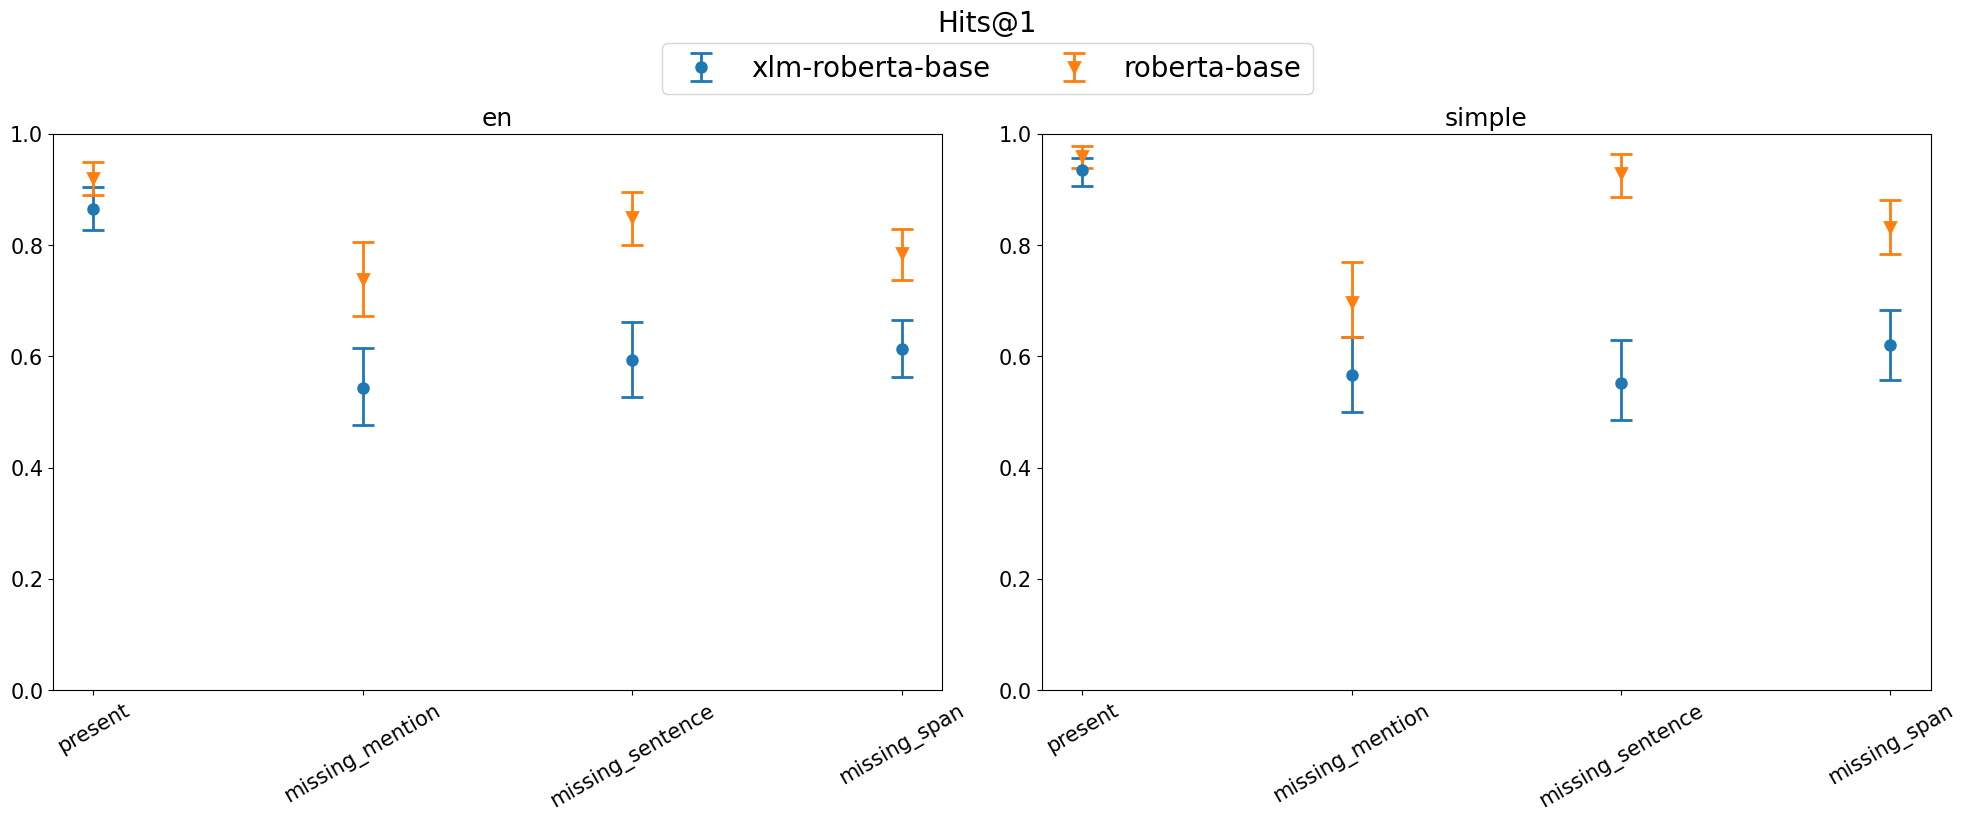

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Hits@1', fontsize=20, y=1.03)

for i, ax in enumerate(axs):
    for column, label, marker, colour in zip(columns[i], labels, markers, colours):
        if column in dfs[langs[i]].columns:
            # if any of the strategies is missing from the stratified results, leave an empty space in the plot for that strategy
            y_points = [stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else -1 for s in strategies]
            y_err = [[stratified_hits_at_k[langs[i]][column][s]['1']['score'] - stratified_hits_at_k[langs[i]][column][s]['1']['cl'][0] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies], [stratified_hits_at_k[langs[i]][column][s]['1']['cl'][1] - stratified_hits_at_k[langs[i]][column][s]['1']['score'] if s in stratified_hits_at_k[langs[i]][column].keys() else 0 for s in strategies]]
            ax.errorbar(strategies, y_points, yerr=y_err, label=label, marker=marker, capsize=8, markersize=markersize, linestyle='None', elinewidth=2, markeredgewidth=2, color=colour)
            # set y axis limits (0-1)
            ax.set_ylim(0, 1)
            # set the title of each subplot to the language
            ax.set_title(langs[i])
            # rotate x labels
            ax.tick_params(axis='x', rotation=30)
            
# set the legend to have 1 row and be at the top of the plot
# only use the labels from the first subplot
handles_, labels_ = axs[0].get_legend_handles_labels()
fig.legend(handles_, labels_, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.005))

plt.tight_layout()

In [ ]:
for column in columns[0]:
    for strategy in strategies:
        # print score and confidence interval for each strategy for each column
        print(f"{column} {strategy} MRR@max: {stratified_mrr_at_k['en'][column][strategy]['max']['score']} {stratified_mrr_at_k['en'][column][strategy]['max']['cl']}")
        print(f"{column} {strategy} Hits@1: {stratified_hits_at_k['en'][column][strategy]['1']['score']} {stratified_hits_at_k['en'][column][strategy]['1']['cl']}")

roberta_two_stage_rank_en present MRR@max: 0.892 [0.8607948459194672, 0.9245227617965712]
roberta_two_stage_rank_en present Hits@1: 0.865 [0.8272058823529411, 0.9044117647058824]
roberta_two_stage_rank_en missing_mention MRR@max: 0.629 [0.5695641496175093, 0.6891015747256957]
roberta_two_stage_rank_en missing_mention Hits@1: 0.543 [0.47692307692307695, 0.6153846153846154]
roberta_two_stage_rank_en missing_sentence MRR@max: 0.662 [0.6045959352262137, 0.7244661905574178]
roberta_two_stage_rank_en missing_sentence Hits@1: 0.594 [0.527363184079602, 0.6616915422885572]
roberta_two_stage_rank_en missing_span MRR@max: 0.697 [0.6544215100410621, 0.7370811393022961]
roberta_two_stage_rank_en missing_span Hits@1: 0.614 [0.5632530120481928, 0.6656626506024096]
roberta_best_en present MRR@max: 0.937 [0.9117219005843575, 0.9604832405498014]
roberta_best_en present Hits@1: 0.921 [0.8897058823529411, 0.9485294117647058]
roberta_best_en missing_mention MRR@max: 0.798 [0.7556116612448311, 0.84748033633

In [ ]:
from scipy.stats import ttest_ind
test_df = dfs['en']
# compute pair-wise p-values for each strategy
for i, column_1 in enumerate(columns[0]):
    for column_2 in columns[0][i+1:]:
        for strategy in strategies:
            ranks_1 = test_df[test_df['missing_category'] == strategy][column_1].tolist()
            ranks_2 = test_df[test_df['missing_category'] == strategy][column_2].tolist()
            
            hits_at_1_1 = [1 if rank <= 1 else 0 for rank in ranks_1]
            hits_at_1_2 = [1 if rank <= 1 else 0 for rank in ranks_2]
            
            mrr_1 = [1 / rank for rank in ranks_1]
            mrr_2 = [1 / rank for rank in ranks_2]
            
            # compute the p-values
            print(f"{column_1} vs {column_2} for {strategy}")
            print(f"\tMRR@max: {ttest_ind(mrr_1, mrr_2)}")
            print(f"\tHits@1: {ttest_ind(hits_at_1_1, hits_at_1_2)}")

roberta_two_stage_rank_en vs roberta_best_en for present
	MRR@max: TtestResult(statistic=-2.04226192818633, pvalue=0.04160898219175772, df=542.0)
	Hits@1: TtestResult(statistic=-2.2287872221774276, pvalue=0.026237320070032225, df=542.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_mention
	MRR@max: TtestResult(statistic=-4.269452225840822, pvalue=2.4665756856964534e-05, df=388.0)
	Hits@1: TtestResult(statistic=-4.0861505766121615, pvalue=5.331645155613239e-05, df=388.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_sentence
	MRR@max: TtestResult(statistic=-6.83584459186385, pvalue=3.0568853865688715e-11, df=400.0)
	Hits@1: TtestResult(statistic=-6.026985705139151, pvalue=3.796053664249604e-09, df=400.0)
roberta_two_stage_rank_en vs roberta_best_en for missing_span
	MRR@max: TtestResult(statistic=-5.490284964723105, pvalue=5.7232048676054226e-08, df=662.0)
	Hits@1: TtestResult(statistic=-4.908086033701197, pvalue=1.1593330974686116e-06, df=662.0)


# Paper Tables

In [29]:
print(dfs['en'].columns)

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_simple_en', 'roberta_simple_multilingual',
       'roberta_full_en', 'roberta_full_multilingual', 'roberta_dyn_mask_en',
       'roberta_only_expansion_en', 'roberta_expansion_en',
       'roberta_full_multilingual-all', 'entqa_rank', 'get_rank',
       'number_candidates'],
      dtype='object')


## Multilingual results

In [67]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'fine_tuning', 'monolingual', 'multilingual']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'fine_tuning', 'monolingual', 'multilingual']}
for lang in dfs:
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']
    
    # random
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df['random_rank'].to_numpy()
        hits_at_1['random'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['random'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # bm25
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df['bm25_mentions_rank'].to_numpy()
        hits_at_1['bm25'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['bm25'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # string_match
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df['fuzzy_match_rank'].to_numpy()
        hits_at_1['string_match'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['string_match'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # fine_tuning
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_simple_{lang}'].to_numpy()
        hits_at_1['fine_tuning'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['fine_tuning'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # monolingual
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_{lang}'].to_numpy()
        hits_at_1['monolingual'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['monolingual'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # multilingual
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_multilingual-all'].to_numpy()
        hits_at_1['multilingual'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'fine_tuning', 'monolingual', 'multilingual']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'fine_tuning', 'monolingual', 'multilingual']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [68]:
# print LaTeX table
print(" & \\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("Baseline & Random", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['random'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['random'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & String Match", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['string_match'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['string_match'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & BM25", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['bm25'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['bm25'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & Simple Fine-Tuning", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['fine_tuning'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['fine_tuning'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

print("Proposed & LocEI$_{\\text{MONO}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['monolingual'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['monolingual'][category]['score']:.3f}", end='')
print(' \\\\')

print("Proposed & LocEI$_{\\text{MULTI}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

 & \multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & & Overall & Present & Missing & Overall & Present & Missing \\\hline
Baseline & Random & 0.107 & 0.115 & 0.103 & 0.243 & 0.259 & 0.236 \\
Baseline & String Match & 0.459 & 0.708 & 0.270 & 0.557 & 0.774 & 0.395 \\
Baseline & BM25 & 0.508 & 0.799 & 0.280 & 0.612 & 0.866 & 0.421 \\
Baseline & Simple Fine-Tuning & 0.584 & 0.883 & 0.350 & 0.649 & 0.907 & 0.451 \\\hline
Proposed & LocEI$_{\text{MONO}}$ & 0.672 & 0.877 & 0.509 & 0.744 & 0.906 & 0.617 \\
Proposed & LocEI$_{\text{MULTI}}$ & 0.726 & 0.909 & 0.579 & 0.789 & 0.929 & 0.678 \\\hline


In [69]:
print('multilingual', hits_at_1_agg['multilingual'])
print('monolingual', hits_at_1_agg['monolingual'])
print('fine-tuned', hits_at_1_agg['fine_tuning'])

multilingual {'present': {'score': 0.9085934777617378, 'sem': 0.005944550560767959}, 'missing': {'score': 0.5789319937550331, 'sem': 0.00975990487341271}, 'all': {'score': 0.7258989747992357, 'sem': 0.005547028799582749}}
monolingual {'present': {'score': 0.8773061669408312, 'sem': 0.006239113496423149}, 'missing': {'score': 0.5093919247307881, 'sem': 0.00979098168884077}, 'all': {'score': 0.6724408423019997, 'sem': 0.005695464078415074}}
fine-tuned {'present': {'score': 0.8827482870587392, 'sem': 0.005887402978822281}, 'missing': {'score': 0.35042088493307555, 'sem': 0.010002285064511056}, 'all': {'score': 0.5840415067046172, 'sem': 0.005898728726373604}}


In [70]:
print('multilingual', mrr_agg['multilingual'])
print('monolingual', mrr_agg['monolingual'])
print('fine-tuned', mrr_agg['fine_tuning'])

multilingual {'present': {'score': 0.9292654962474337, 'sem': 0.004727023581786076}, 'missing': {'score': 0.6784215637622996, 'sem': 0.008085125141891641}, 'all': {'score': 0.7885753585655768, 'sem': 0.004500297155432904}}
monolingual {'present': {'score': 0.90560118655408, 'sem': 0.00499054413411686}, 'missing': {'score': 0.6169631913255373, 'sem': 0.007714201453829325}, 'all': {'score': 0.7437984275797027, 'sem': 0.004558105449393685}}
fine-tuned {'present': {'score': 0.90665564564549, 'sem': 0.004780577316807266}, 'missing': {'score': 0.4506328172336615, 'sem': 0.009110878252962555}, 'all': {'score': 0.6489047628556013, 'sem': 0.005191326456684886}}


## English results

In [71]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'entqa', 'get', 'fine_tuning', 'monolingual']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['random', 'bm25', 'string_match', 'entqa', 'get', 'fine_tuning', 'monolingual']}
test_df = dfs['en']
df_present = test_df[test_df['missing_category'] == 'present']
df_missing = test_df[test_df['missing_category'] != 'present']

# random
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['random_rank'].to_numpy()
    hits_at_1['random'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['random'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# bm25
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['bm25_mentions_rank'].to_numpy()
    hits_at_1['bm25'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['bm25'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# string_match
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['fuzzy_match_rank'].to_numpy()
    hits_at_1['string_match'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['string_match'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# entqa
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['entqa_rank'].to_numpy()
    hits_at_1['entqa'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['entqa'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# get
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['get_rank'].to_numpy()
    hits_at_1['get'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['get'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# fine_tuning
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df[f'roberta_simple_en'].to_numpy()
    hits_at_1['fine_tuning'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['fine_tuning'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# monolingual
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df[f'roberta_full_en'].to_numpy()
    hits_at_1['monolingual'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['monolingual'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

In [72]:
# print LaTeX table
print(" & \\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("Baseline & Random", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['random'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['random'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & String Match", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['string_match'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['string_match'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & BM25", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['bm25'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['bm25'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & EntQA$_{\\text{RET}}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['entqa'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['entqa'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & GET", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['get'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['get'][category]['score']:.3f}", end='')
print(' \\\\')

print("Baseline & Simple Fine-Tuning", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['fine_tuning'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['fine_tuning'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

print("Proposed & LocEI$_{\\text{MONO}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['monolingual'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['monolingual'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

 & \multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & & Overall & Present & Missing & Overall & Present & Missing \\\hline
Baseline & Random & 0.079 & 0.110 & 0.067 & 0.202 & 0.240 & 0.187 \\
Baseline & String Match & 0.391 & 0.732 & 0.264 & 0.489 & 0.796 & 0.374 \\
Baseline & BM25 & 0.439 & 0.838 & 0.290 & 0.538 & 0.894 & 0.404 \\
Baseline & EntQA$_{\text{RET}} & 0.099 & 0.136 & 0.085 & 0.234 & 0.278 & 0.217 \\
Baseline & GET & 0.391 & 0.827 & 0.228 & 0.469 & 0.851 & 0.326 \\
Baseline & Simple Fine-Tuning & 0.443 & 0.860 & 0.287 & 0.522 & 0.888 & 0.385 \\\hline
Proposed & LocEI$_{\text{MONO}}$ & 0.677 & 0.879 & 0.602 & 0.741 & 0.902 & 0.681 \\\hline


In [73]:
print('bm25', hits_at_1['bm25'])
print('monolingual', hits_at_1['monolingual'])
print('simple', hits_at_1['fine_tuning'])

bm25 {'present': {'score': 0.8382352941176471, 'sem': 0.022327515816775074}, 'missing': {'score': 0.28983516483516486, 'sem': 0.01681471188563433}, 'all': {'score': 0.439, 'sem': 0.015693278816104685}}
monolingual {'present': {'score': 0.8786764705882353, 'sem': 0.01979714501687693}, 'missing': {'score': 0.6016483516483516, 'sem': 0.0181442484986643}, 'all': {'score': 0.677, 'sem': 0.014787528529135624}}
simple {'present': {'score': 0.8602941176470589, 'sem': 0.021020661123688257}, 'missing': {'score': 0.28708791208791207, 'sem': 0.01676716943636733}, 'all': {'score': 0.443, 'sem': 0.015708309902723462}}


## Simple English results

In [74]:
dfs['simple'].columns

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_simple_simple',
       'roberta_simple_multilingual', 'roberta_full_simple',
       'roberta_full_multilingual', 'roberta_dyn_mask_simple',
       'roberta_only_expansion_simple', 'roberta_expansion_simple',
       'roberta_full_multilingual-all', 'get_rank',
       'roberta_dyn_mask_no_neg_simple', 'roberta_pointwise_simple',
       'number_candidates'],
      dtype='object')

In [75]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['pointwise', 'ranking']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['pointwise', 'ranking']}
test_df = dfs['simple']
df_present = test_df[test_df['missing_category'] == 'present']
df_missing = test_df[test_df['missing_category'] != 'present']

# pointwise
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['roberta_pointwise_simple'].to_numpy()
    hits_at_1['pointwise'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['pointwise'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# ranking
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['roberta_full_simple'].to_numpy()
    hits_at_1['ranking'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['ranking'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

In [76]:
# print LaTeX table
print("\\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print("& Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("Pointwise Loss", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['pointwise'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['pointwise'][category]['score']:.3f}", end='')
print(' \\\\')

print("Ranking Loss", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['ranking'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['ranking'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
& Overall & Present & Missing & Overall & Present & Missing \\\hline
Pointwise Loss & 0.641 & 0.891 & 0.477 & 0.712 & 0.922 & 0.574 \\
Ranking Loss & 0.658 & 0.907 & 0.495 & 0.731 & 0.930 & 0.601 \\\hline


In [77]:
print('pointwise', hits_at_1['pointwise'])
print('ranking', hits_at_1['ranking'])

pointwise {'present': {'score': 0.8914141414141414, 'sem': 0.01563431297417061}, 'missing': {'score': 0.4768211920529801, 'sem': 0.020322839028925586}, 'all': {'score': 0.641, 'sem': 0.015169673694578929}}
ranking {'present': {'score': 0.9065656565656566, 'sem': 0.014625317651850052}, 'missing': {'score': 0.49503311258278143, 'sem': 0.02034370763764563}, 'all': {'score': 0.658, 'sem': 0.01500119995200384}}


In [78]:
print('pointwise', mrr['pointwise'])
print('ranking', mrr['ranking'])

pointwise {'present': {'score': 0.9216327172511984, 'sem': 0.011711909313311527}, 'missing': {'score': 0.5744634996519381, 'sem': 0.017238334244843955}, 'all': {'score': 0.7119425098212451, 'sem': 0.012599486159356714}}
ranking {'present': {'score': 0.9300094620616634, 'sem': 0.01135768992663005}, 'missing': {'score': 0.6006052479351741, 'sem': 0.016809389618940365}, 'all': {'score': 0.7310493167292639, 'sem': 0.012217314744609358}}


## Zero-shot results

In [79]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual', 'zero-shot', 'monolingual']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual', 'zero-shot', 'monolingual']}
for lang in ['af', 'fr', 'ga', 'gu', 'kk', 'ms', 'pt', 'simple', 'sk']:
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']

    # multilingual
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_multilingual-all'].to_numpy()
        hits_at_1['multilingual'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # monolingual
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_{lang}'].to_numpy()
        hits_at_1['monolingual'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['monolingual'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

    # zero-shot
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df['roberta_full_multilingual'].to_numpy()
        hits_at_1['zero-shot'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['zero-shot'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual', 'zero-shot', 'monolingual']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual', 'zero-shot', 'monolingual']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [80]:
# print LaTeX table
print("\\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("LocEI$_{\\text{MONO}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['monolingual'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['monolingual'][category]['score']:.3f}", end='')
print(' \\\\')

print("LocEI$_{\\text{MULTI-12}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['zero-shot'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['zero-shot'][category]['score']:.3f}", end='')
print(' \\\\')

print("LocEI$_{\\text{MULTI-21}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
LocEI$_{\text{MONO}}$ & 0.647 & 0.873 & 0.486 & 0.718 & 0.902 & 0.588 \\
LocEI$_{\text{MULTI-12}}$ & 0.690 & 0.887 & 0.541 & 0.755 & 0.913 & 0.636 \\
LocEI$_{\text{MULTI-21}}$ & 0.709 & 0.901 & 0.570 & 0.772 & 0.923 & 0.662 \\\hline


In [81]:
print('multilingual', hits_at_1_agg['multilingual'])
print('zero-shot', hits_at_1_agg['zero-shot'])
print('monolingual', hits_at_1_agg['monolingual'])

multilingual {'present': {'score': 0.9005307142205825, 'sem': 0.012035965709623564}, 'missing': {'score': 0.5703957275434851, 'sem': 0.01914493614642801}, 'all': {'score': 0.7092249723670913, 'sem': 0.010942270707321927}}
zero-shot {'present': {'score': 0.887036155095982, 'sem': 0.01151850668221065}, 'missing': {'score': 0.5406112586486643, 'sem': 0.019999602332854867}, 'all': {'score': 0.6902725346239558, 'sem': 0.01096616139833361}}
monolingual {'present': {'score': 0.873080548445541, 'sem': 0.012270023597038422}, 'missing': {'score': 0.4858413148231589, 'sem': 0.019174277388774707}, 'all': {'score': 0.6469311180732369, 'sem': 0.011131710647568039}}


In [82]:
print('multilingual', mrr_agg['multilingual'])
print('zero-shot', mrr_agg['zero-shot'])
print('monolingual', mrr_agg['monolingual'])

multilingual {'present': {'score': 0.9229451102053259, 'sem': 0.009561054036924263}, 'missing': {'score': 0.6621430716155878, 'sem': 0.016262336134927325}, 'all': {'score': 0.7717963166483186, 'sem': 0.008989540464512199}}
zero-shot {'present': {'score': 0.9125131393245532, 'sem': 0.009543024038066403}, 'missing': {'score': 0.6355488308825517, 'sem': 0.016856309594944476}, 'all': {'score': 0.755179740705434, 'sem': 0.009217307434140534}}
monolingual {'present': {'score': 0.9022689157958799, 'sem': 0.009839044673835328}, 'missing': {'score': 0.5884531972115616, 'sem': 0.015147226177484735}, 'all': {'score': 0.7184496452759789, 'sem': 0.008955178237303714}}


## Starting model results

In [83]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {'score': None, 'sem': None} for category in ['present', 'missing', 'all']} for method in ['BERT', 'RoBERTa', 'T5']}
mrr = {method: {category: {'score': None, 'sem': None} for category in ['present', 'missing', 'all']} for method in ['BERT', 'RoBERTa', 'T5']}
test_df = pd.read_parquet('/dlabdata1/tsoares/linkrec-llms/data_modelling/benchmark_real/test_ranking_scores_all.parquet')
df_present = test_df[test_df['missing_category'] == 'present']
df_missing = test_df[test_df['missing_category'] != 'present']

# bert
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['bert_two_stage_v2_rank'].to_numpy()
    hits_at_1['BERT'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['BERT'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# roberta
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['roberta_two_stage_v2_rank'].to_numpy()
    hits_at_1['RoBERTa'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['RoBERTa'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# t5
for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
    ranks = df['t5_two_stage_v2_rank'].to_numpy()
    hits_at_1['T5'][category] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
    mrr['T5'][category] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

In [84]:
# print LaTeX table
print("\\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("BERT", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['BERT'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['BERT'][category]['score']:.3f}", end='')
print(' \\\\')

print("RoBERTa", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['RoBERTa'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['RoBERTa'][category]['score']:.3f}", end='')
print(' \\\\')

print("T5$^{\\text{enc}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1['T5'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr['T5'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
BERT & 0.666 & 0.916 & 0.492 & 0.738 & 0.940 & 0.598 \\
RoBERTa & 0.851 & 0.957 & 0.777 & 0.890 & 0.968 & 0.835 \\
T5$^{\text{enc}}$ & 0.710 & 0.929 & 0.558 & 0.774 & 0.952 & 0.650 \\\hline


In [85]:
print('bert', hits_at_1['BERT'])
print('roberta', hits_at_1['RoBERTa'])
print('t5', hits_at_1['T5'])

bert {'present': {'score': 0.9164768413059985, 'sem': 0.007623796849487881}, 'missing': {'score': 0.49234828496042216, 'sem': 0.0114845646385793}, 'all': {'score': 0.6662515566625156, 'sem': 0.008320338101487629}}
roberta {'present': {'score': 0.9567198177676538, 'sem': 0.005607174061451515}, 'missing': {'score': 0.7767810026385225, 'sem': 0.009565557072090837}, 'all': {'score': 0.8505603985056039, 'sem': 0.006290680979466945}}
t5 {'present': {'score': 0.929384965831435, 'sem': 0.0070591680490247255}, 'missing': {'score': 0.5577836411609499, 'sem': 0.011408950123033182}, 'all': {'score': 0.7101494396014943, 'sem': 0.00800523670906193}}


In [86]:
print('bert', mrr['BERT'])
print('roberta', mrr['RoBERTa'])
print('t5', mrr['T5'])

bert {'present': {'score': 0.9399681974863595, 'sem': 0.005664884402287306}, 'missing': {'score': 0.5976737410339715, 'sem': 0.00955373282067021}, 'all': {'score': 0.7380229935706449, 'sem': 0.006781513284343846}}
roberta {'present': {'score': 0.9680797675920503, 'sem': 0.004261389950343502}, 'missing': {'score': 0.8354138154355056, 'sem': 0.007305244798547184}, 'all': {'score': 0.8898101600775259, 'sem': 0.0047910168326932194}}
t5 {'present': {'score': 0.9517920755369146, 'sem': 0.0050012020187770205}, 'missing': {'score': 0.649625128009099, 'sem': 0.009441360044083667}, 'all': {'score': 0.7735211024468739, 'sem': 0.0064890841841313855}}


## Impact of training stages

In [87]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'stage_2', 'stage_1+2']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'stage_2', 'stage_1+2']}
for lang in ['en']:
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']

    # stage_1
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_simple_{lang}'].to_numpy()
        hits_at_1['stage_1'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['stage_1'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # stage_2
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_only_expansion_{lang}'].to_numpy()
        hits_at_1['stage_2'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['stage_2'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # stage_1+2
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_{lang}'].to_numpy()
        hits_at_1['stage_1+2'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['stage_1+2'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'stage_2', 'stage_1+2']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'stage_2', 'stage_1+2']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [88]:
# print LaTeX table
print("\\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("Warm Start", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['stage_1'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['stage_1'][category]['score']:.3f}", end='')
print(' \\\\')

print("Expansion", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['stage_2'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['stage_2'][category]['score']:.3f}", end='')
print(' \\\\')

print("Warm Start + Expansion", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['stage_1+2'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['stage_1+2'][category]['score']:.3f}", end='')
print(' \\\\\\hline')
    

\multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
Warm Start & 0.443 & 0.860 & 0.287 & 0.522 & 0.888 & 0.385 \\
Expansion & 0.678 & 0.886 & 0.600 & 0.745 & 0.911 & 0.684 \\
Warm Start + Expansion & 0.677 & 0.879 & 0.602 & 0.741 & 0.902 & 0.681 \\\hline


In [89]:
print('stage_1', hits_at_1_agg['stage_1'])
print('stage_2', hits_at_1_agg['stage_2'])
print('stage_1+2', hits_at_1_agg['stage_1+2'])

stage_1 {'present': {'score': 0.8602941176470589, 'sem': 0.021020661123688257}, 'missing': {'score': 0.28708791208791207, 'sem': 0.01676716943636733}, 'all': {'score': 0.443, 'sem': 0.015708309902723462}}
stage_2 {'present': {'score': 0.8860294117647058, 'sem': 0.019267972249438426}, 'missing': {'score': 0.6002747252747253, 'sem': 0.018154744614582493}, 'all': {'score': 0.678, 'sem': 0.014775520295407536}}
stage_1+2 {'present': {'score': 0.8786764705882353, 'sem': 0.01979714501687693}, 'missing': {'score': 0.6016483516483516, 'sem': 0.0181442484986643}, 'all': {'score': 0.677, 'sem': 0.014787528529135624}}


In [90]:
print('stage_1', mrr_agg['stage_1'])
print('stage_2', mrr_agg['stage_2'])
print('stage_1+2', mrr_agg['stage_1+2'])

stage_1 {'present': {'score': 0.888239578104634, 'sem': 0.017235869811354537}, 'missing': {'score': 0.384856871253959, 'sem': 0.015309390987171441}, 'all': {'score': 0.5217769675173426, 'sem': 0.014013251152047223}}
stage_2 {'present': {'score': 0.910824455427348, 'sem': 0.015482564503100118}, 'missing': {'score': 0.6835709436293899, 'sem': 0.01502849963964155}, 'all': {'score': 0.7453838988384344, 'sem': 0.012151585118093878}}
stage_1+2 {'present': {'score': 0.9018353663761152, 'sem': 0.01635107362504916}, 'missing': {'score': 0.6811905286307974, 'sem': 0.015131318339052279}, 'all': {'score': 0.7412059244975238, 'sem': 0.012278593679006355}}


## Impact of novelties

In [91]:
dfs['cs'].columns

Index(['source_title', 'source_ID', 'target_title', 'context', 'section',
       'mention_present', 'source_lead', 'first_version', 'second_version',
       'direct_match', 'missing_category', 'negative_contexts',
       'current_links', 'target_lead', 'random_rank', 'bm25_mentions_rank',
       'fuzzy_match_rank', 'roberta_simple_cs', 'roberta_simple_multilingual',
       'roberta_full_cs', 'roberta_full_multilingual', 'roberta_dyn_mask_cs',
       'roberta_only_expansion_cs', 'roberta_expansion_cs',
       'roberta_full_multilingual-all', 'roberta_dyn_mask_no_neg_cs',
       'number_candidates'],
      dtype='object')

In [92]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'corrupt_no_neg', 'corrupt', 'stage_2', 'knowledge']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'corrupt_no_neg', 'corrupt', 'stage_2', 'knowledge']}
for lang in dfs:
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']
    
    # stage_1
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_simple_{lang}'].to_numpy()
        hits_at_1['stage_1'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks] / np.sqrt(len(ranks)))}
        mrr['stage_1'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks] / np.sqrt(len(ranks)))}
    
    # corrupt_no_neg
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_dyn_mask_no_neg_{lang}'].to_numpy()
        hits_at_1['corrupt_no_neg'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks] / np.sqrt(len(ranks)))}
        mrr['corrupt_no_neg'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks] / np.sqrt(len(ranks)))}
    
    # corrupt
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_dyn_mask_{lang}'].to_numpy()
        hits_at_1['corrupt'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks] / np.sqrt(len(ranks)))}
        mrr['corrupt'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks] / np.sqrt(len(ranks)))}
    
    # stage_2
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_expansion_{lang}'].to_numpy()
        hits_at_1['stage_2'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks] / np.sqrt(len(ranks)))}
        mrr['stage_2'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks] / np.sqrt(len(ranks)))}
    
    # mention
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        ranks = df[f'roberta_full_{lang}'].to_numpy()
        hits_at_1['knowledge'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks] / np.sqrt(len(ranks)))}
        mrr['knowledge'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks] / np.sqrt(len(ranks)))}
    
    print(lang, 
          hits_at_1['corrupt_no_neg']['all'][lang]['score'], 
          hits_at_1['corrupt']['all'][lang]['score'], 
          hits_at_1['corrupt_no_neg']['present'][lang]['score'],
          hits_at_1['corrupt']['present'][lang]['score'],
          hits_at_1['corrupt_no_neg']['missing'][lang]['score'],
          hits_at_1['corrupt']['missing'][lang]['score'],
          mrr['corrupt_no_neg']['all'][lang]['score'],
          mrr['corrupt']['all'][lang]['score'],
          mrr['corrupt_no_neg']['present'][lang]['score'],
          mrr['corrupt']['present'][lang]['score'],
          mrr['corrupt_no_neg']['missing'][lang]['score'],
          mrr['corrupt']['missing'][lang]['score']
          )
        
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'corrupt_no_neg', 'corrupt', 'stage_2', 'knowledge']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['stage_1', 'corrupt_no_neg', 'corrupt', 'stage_2', 'knowledge']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

ms 0.531 0.548 0.7780612244897959 0.8239795918367347 0.3717105263157895 0.37006578947368424 0.6211305347130579 0.6281829876175472 0.8302711343377168 0.8635702830619109 0.48628988495505415 0.4764201260810495
sk 0.539 0.528 0.8618925831202046 0.8695652173913043 0.33169129720853857 0.30870279146141216 0.6183541540919801 0.6037941221618897 0.8942933615284537 0.8961746153059705 0.4411912146705333 0.4160752833780873
pt 0.477 0.489 0.8343373493975904 0.8674698795180723 0.2994011976047904 0.3008982035928144 0.5627213160132378 0.5661960291004061 0.8737734684756308 0.8912864042530007 0.4081265336516893 0.4046241660006136
af 0.5503875968992248 0.5271317829457365 0.8325471698113207 0.8490566037735849 0.30062630480167013 0.24217118997912318 0.6354705570920324 0.6039317660883258 0.8794199107027614 0.8800031899014 0.41953208959527016 0.3595595663038928
cy 0.7620396600566572 0.7535410764872521 0.9636363636363636 0.9727272727272728 0.42857142857142855 0.39097744360902253 0.8208277279110096 0.8163684686

In [93]:
# print LaTeX table
print("\\multirow{2}{*}{Method} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print('simple fine-tuning', end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['stage_1'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['stage_1'][category]['score']:.3f}", end='')
print(' \\\\')

print('\\hspace{4mm}+dynamic context removal', end='')
for category in ['all', 'present', 'missing']:
    print(" & \\multirow{2}{*}{" + f"{hits_at_1_agg['corrupt_no_neg'][category]['score']:.3f}" + "}", end='')
for category in ['all', 'present', 'missing']:
    print(" & \\multirow{2}{*}{" + f"{mrr_agg['corrupt_no_neg'][category]['score']:.3f}" + "}", end='')
print(' \\\\')
print('\\hspace{4mm}(only on positives) \\\\')


print('\\hspace{4mm}+dynamic context removal', end='')
for category in ['all', 'present', 'missing']:
    print(" & \\multirow{2}{*}{" + f"{hits_at_1_agg['corrupt'][category]['score']:.3f}" + "}", end='')
for category in ['all', 'present', 'missing']:
    print(" & \\multirow{2}{*}{" + f"{mrr_agg['corrupt'][category]['score']:.3f}" + "}", end='')
print(' \\\\')
print('\\hspace{4mm}(on negatives) \\\\')

print('\\hspace{4mm}+second stage', end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['stage_2'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['stage_2'][category]['score']:.3f}", end='')
print(' \\\\')

print('\\hspace{4mm}+knowledge injection', end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['knowledge'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['knowledge'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Method} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
simple fine-tuning & 0.584 & 0.883 & 0.350 & 0.649 & 0.907 & 0.451 \\
\hspace{4mm}+dynamic context removal & \multirow{2}{*}{0.541} & \multirow{2}{*}{0.782} & \multirow{2}{*}{0.372} & \multirow{2}{*}{0.626} & \multirow{2}{*}{0.828} & \multirow{2}{*}{0.487} \\
\hspace{4mm}(only on positives) \\
\hspace{4mm}+dynamic context removal & \multirow{2}{*}{0.574} & \multirow{2}{*}{0.838} & \multirow{2}{*}{0.376} & \multirow{2}{*}{0.649} & \multirow{2}{*}{0.873} & \multirow{2}{*}{0.486} \\
\hspace{4mm}(on negatives) \\
\hspace{4mm}+second stage & 0.657 & 0.850 & 0.500 & 0.733 & 0.889 & 0.609 \\
\hspace{4mm}+knowledge injection & 0.672 & 0.877 & 0.509 & 0.744 & 0.906 & 0.617 \\\hline


In [94]:
keys = list(hits_at_1_agg.keys())
for i, key in enumerate(keys):
    print(key, hits_at_1_agg[key])
    if i > 0:
        for strategy in ['all', 'present', 'missing']:
            print(strategy, hits_at_1_agg[key][strategy]['score'] - hits_at_1_agg[key][strategy]['sem'] * 1.96 - hits_at_1_agg[keys[i-1]][strategy]['score'] - hits_at_1_agg[keys[i-1]][strategy]['sem'] * 1.96)

stage_1 {'present': {'score': 0.8827482870587392, 'sem': 0.005887402978822281}, 'missing': {'score': 0.35042088493307555, 'sem': 0.010002285064511054}, 'all': {'score': 0.5840415067046172, 'sem': 0.005898728726373605}}
corrupt_no_neg {'present': {'score': 0.7817388150942681, 'sem': 0.007314577654993239}, 'missing': {'score': 0.3721888494303504, 'sem': 0.00960206656057691}, 'all': {'score': 0.5410364113575765, 'sem': 0.005986729499957759}}
all -0.06630059347065018
present -0.12688535400674944
missing -0.016656564687897557
corrupt {'present': {'score': 0.8379175238823772, 'sem': 0.0063248658725909}, 'missing': {'score': 0.3757046048762926, 'sem': 0.009691922790561696}, 'all': {'score': 0.5738447815115133, 'sem': 0.005630162646745928}}
all 0.010039261546397598
present 0.029445399474044183
missing -0.0343004636822895
stage_2 {'present': {'score': 0.8504666810936016, 'sem': 0.006748507623469655}, 'missing': {'score': 0.4995565214631969, 'sem': 0.009787285696519802}, 'all': {'score': 0.65690

In [95]:
keys = list(hits_at_1.keys())
for i, key in enumerate(keys):
    print(key, hits_at_1[key]['present']['en'], hits_at_1[key]['missing']['en'], hits_at_1[key]['all']['en'])
    if i > 0:
        for strategy in ['all', 'present', 'missing']:
            print(strategy, hits_at_1[key][strategy]['en']['score'] - hits_at_1[key][strategy]['en']['sem'] * 1.96 - hits_at_1[keys[i-1]][strategy]['en']['score'] - hits_at_1[keys[i-1]][strategy]['en']['sem'] * 1.96)

stage_1 {'score': 0.8602941176470589, 'sem': 0.021020661123688254} {'score': 0.28708791208791207, 'sem': 0.01676716943636733} {'score': 0.443, 'sem': 0.015708309902723462}
corrupt_no_neg {'score': 0.8051470588235294, 'sem': 0.024016329653836075} {'score': 0.30357142857142855, 'sem': 0.017041312775366562} {'score': 0.44, 'sem': 0.015697133496278867}
all -0.06455466906204455
present -0.14341956074747714
missing -0.049781108651481935
corrupt {'score': 0.8455882352941176, 'sem': 0.021909638258677255} {'score': 0.33379120879120877, 'sem': 0.017477404475623664} {'score': 0.473, 'sem': 0.015788318466511877}
all -0.028711485847069854
present -0.04957372063793793
missing -0.037436905592160626
stage_2 {'score': 0.875, 'sem': 0.02005277962249212} {'score': 0.5631868131868132, 'sem': 0.018382662738017325} {'score': 0.648, 'sem': 0.015102847413650183}
all 0.11445331487488239
present -0.052834574341209625
missing 0.1591098726568681
knowledge {'score': 0.8786764705882353, 'sem': 0.019797145016876933}

In [96]:
keys = list(mrr_agg.keys())
for i, key in enumerate(keys):
    print(key, mrr_agg[key])
    if i > 0:
        for strategy in ['all', 'present', 'missing']:
            print(strategy, mrr_agg[key][strategy]['score'] - mrr_agg[key][strategy]['sem'] * 1.96 - mrr_agg[keys[i-1]][strategy]['score'] - mrr_agg[keys[i-1]][strategy]['sem'] * 1.96)

stage_1 {'present': {'score': 0.90665564564549, 'sem': 0.004780577316807266}, 'missing': {'score': 0.4506328172336615, 'sem': 0.009110878252962555}, 'all': {'score': 0.6489047628556013, 'sem': 0.005191326456684886}}
corrupt_no_neg {'present': {'score': 0.8277167891182093, 'sem': 0.005993491488203726}, 'missing': {'score': 0.48730946339203457, 'sem': 0.00843600880164528}, 'all': {'score': 0.6259642477023171, 'sem': 0.005083092931008861}}
all -0.04307837715316396
present -0.1000560313851021
missing 0.002284747531341707
corrupt {'present': {'score': 0.8729420375358521, 'sem': 0.005229510162452298}, 'missing': {'score': 0.4856252120040033, 'sem': 0.007993408345386593}, 'all': {'score': 0.64932787247316, 'sem': 0.00474767654271254}}
all 0.00409531660234908
present 0.023228165182356892
missing -0.03388590899621373
stage_2 {'present': {'score': 0.8886353379309403, 'sem': 0.005204316286035478}, 'missing': {'score': 0.6091975469811577, 'sem': 0.008271671608518577}, 'all': {'score': 0.7327207148

In [97]:
keys = list(mrr.keys())
for i, key in enumerate(keys):
    print(key, mrr[key]['present']['en'], mrr[key]['missing']['en'], mrr[key]['all']['en'], mrr[key]['all']['en'])
    if i > 0:
        for strategy in ['all', 'present', 'missing']:
            print(strategy, mrr[key][strategy]['en']['score'] - mrr[key][strategy]['en']['sem'] * 1.96 - mrr[keys[i-1]][strategy]['en']['score'] - mrr[keys[i-1]][strategy]['en']['sem'] * 1.96)

stage_1 {'score': 0.888239578104634, 'sem': 0.017235869811354533} {'score': 0.384856871253959, 'sem': 0.01530939098717144} {'score': 0.5217769675173426, 'sem': 0.014013251152047221} {'score': 0.5217769675173426, 'sem': 0.014013251152047221}
corrupt_no_neg {'score': 0.8424901662445017, 'sem': 0.019987967172499465} {'score': 0.41543933161486196, 'sem': 0.01522480497027135} {'score': 0.5315971586341238, 'sem': 0.013730190548971948} {'score': 0.5315971586341238, 'sem': 0.013730190548971948}
all -0.044556954617216364
present -0.11870813234848618
missing -0.029264563715684925
corrupt {'score': 0.8750459263412509, 'sem': 0.018177628081938707} {'score': 0.4239361918397491, 'sem': 0.01580406903225575} {'score': 0.5466380396241576, 'sem': 0.01403979573844087} {'score': 0.5466380396241576, 'sem': 0.01403979573844087}
all -0.039388292133295394
present -0.04224880660194965
missing -0.05231973282006595
stage_2 {'score': 0.9023646684023364, 'sem': 0.016093847531950926} {'score': 0.6511721175930214, '

# All languages

In [9]:
dfs = {}
# use glob to select all files in test_data/ that don't include "mention_map"
files = glob('test_data_full/*')
files = [file for file in files if 'mention_map' not in file]
for file in tqdm(files):
    basename = os.path.basename(file)
    lang = basename.split('.')[0]
    dfs[lang] = pd.read_parquet(file)
    if len(dfs[lang]) == 0:
        del dfs[lang]
        continue
    dfs[lang]['missing_category'] = dfs[lang]['missing_category'].fillna('present')
    dfs[lang]['number_candidates'] = dfs[lang]['negative_contexts'].apply(lambda x: x.count("'context'") + 1)

100%|██████████| 106/106 [01:03<00:00,  1.68it/s]


In [10]:
# columns = ['random_rank', 'bm25_mentions_rank',	'fuzzy_match_rank']
columns = ['bm25_mentions_rank', 'fuzzy_match_rank']
partial_matches = ['roberta']

In [11]:
mrr_at_k = {}
for lang in tqdm(dfs):
    mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                mrr_at_k[lang][column] = compute_mrr(dfs[lang][column].tolist())

100%|██████████| 105/105 [00:00<00:00, 476.93it/s]


In [12]:
stratified_mrr_at_k = {}
for lang in tqdm(dfs):
    stratified_mrr_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_mrr_at_k[lang][column] = compute_stratified_mrr(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

 46%|████▌     | 48/105 [00:00<00:00, 154.12it/s]

100%|██████████| 105/105 [00:00<00:00, 160.73it/s]


In [13]:
hits_at_k = {}
for lang in tqdm(dfs):
    hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                hits_at_k[lang][column] = compute_hits(dfs[lang][column].tolist())


100%|██████████| 105/105 [00:00<00:00, 538.34it/s]


In [14]:
stratified_hits_at_k = {}
for lang in tqdm(dfs):
    stratified_hits_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_hits_at_k[lang][column] = compute_stratified_hits(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

 29%|██▊       | 30/105 [00:00<00:00, 147.78it/s]

100%|██████████| 105/105 [00:00<00:00, 153.21it/s]


In [15]:
ndcg_at_k = {}
for lang in tqdm(dfs):
    ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                ndcg_at_k[lang][column] = compute_ndcg(dfs[lang][column].tolist())

100%|██████████| 105/105 [00:00<00:00, 535.12it/s]


In [16]:
stratified_ndcg_at_k = {}
for lang in tqdm(dfs):
    stratified_ndcg_at_k[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_ndcg_at_k[lang][column] = compute_stratified_ndcg(dfs[lang][column].tolist(), dfs[lang]['missing_category'].tolist(), dfs[lang]['missing_category'].unique().tolist())

 59%|█████▉    | 62/105 [00:00<00:00, 118.41it/s]

100%|██████████| 105/105 [00:00<00:00, 135.37it/s]


In [17]:
std = {}
for lang in tqdm(dfs):
    std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            std[lang][column] = dfs[lang][column].std()
        for partial_match in partial_matches:
            if partial_match in column:
                std[lang][column] = dfs[lang][column].std()

100%|██████████| 105/105 [00:00<00:00, 3653.91it/s]


In [18]:
stratified_std = {}
for lang in tqdm(dfs):
    stratified_std[lang] = {}
    for column in dfs[lang].columns:
        if column in columns:
            stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()
        for partial_match in partial_matches:
            if partial_match in column:
                stratified_std[lang][column] = dfs[lang][column].groupby(dfs[lang]['missing_category']).std()

100%|██████████| 105/105 [00:00<00:00, 588.07it/s]


## Full table

In [25]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
for lang in dfs:
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']

    # multilingual-large
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df[f'roberta_full_multilingual-all'].to_numpy()
        hits_at_1['multilingual-large'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-large'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # multilingual-small
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df[f'roberta_full_multilingual'].to_numpy()
        hits_at_1['multilingual-small'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-small'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # bm25
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['bm25_mentions_rank'].to_numpy()
        hits_at_1['bm25'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['bm25'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # string match
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['fuzzy_match_rank'].to_numpy()
        hits_at_1['string_match'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['string_match'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # random 
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['random_rank'].to_numpy()
        hits_at_1['random'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['random'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [26]:
print(len(hits_at_1['bm25']['all']))

105


In [28]:
# print LaTeX table
print("\\multirow{2}{*}{Variant} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("Random", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['random'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['random'][category]['score']:.3f}", end='')
print(' \\\\')

print("String Match", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['string_match'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-small'][category]['score']:.3f}", end='')
print(' \\\\')

print("BM25", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['bm25'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['bm25'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

print("xLocEI$_{12}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-small'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-small'][category]['score']:.3f}", end='')
print(' \\\\')

print("xLocEI$_{21}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-large'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-large'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Variant} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
Random & 0.141 & 0.129 & 0.142 & 0.279 & 0.281 & 0.273 \\
String Match & 0.444 & 0.716 & 0.268 & 0.758 & 0.891 & 0.675 \\
BM25 & 0.465 & 0.746 & 0.289 & 0.585 & 0.831 & 0.431 \\\hline
xLocEI$_{12}$ & 0.688 & 0.858 & 0.583 & 0.758 & 0.891 & 0.675 \\
xLocEI$_{21}$ & 0.709 & 0.879 & 0.596 & 0.772 & 0.906 & 0.683 \\\hline


In [29]:
print('multilingual-small', hits_at_1_agg['multilingual-small'])
print('multilingual-large', hits_at_1_agg['multilingual-large'])

multilingual-small {'present': {'score': 0.8583700986551873, 'sem': 0.0045365861073799075}, 'missing': {'score': 0.5830083801246931, 'sem': 0.006566277675856657}, 'all': {'score': 0.6882949546078845, 'sem': 0.004769841271141875}}
multilingual-large {'present': {'score': 0.8790815503322982, 'sem': 0.004285773316512376}, 'missing': {'score': 0.5964160343344664, 'sem': 0.0068248075019940535}, 'all': {'score': 0.7089081905530512, 'sem': 0.004702768154722118}}


In [30]:
print('multilingual-small', mrr_agg['multilingual-small'])
print('multilingual-large', mrr_agg['multilingual-large'])

multilingual-small {'present': {'score': 0.8906605144859009, 'sem': 0.003548725466106421}, 'missing': {'score': 0.6748259867174046, 'sem': 0.005368989932847901}, 'all': {'score': 0.7578329425305623, 'sem': 0.0037351310941423008}}
multilingual-large {'present': {'score': 0.9058504851071372, 'sem': 0.0034518330049438484}, 'missing': {'score': 0.6831928444683092, 'sem': 0.0058115580314066365}, 'all': {'score': 0.7719374042745443, 'sem': 0.0037875885210743015}}


# Only zero-shot languages

In [34]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
for lang in dfs:
    if lang in ['af', 'cs', 'cy', 'en', 'fr', 'ga', 'gu', 'hi', 'is', 'it', 'ja', 'kk', 'kn', 'ms', 'pt', 'simple', 'sk', 'sw', 'ur', 'uz']:
        continue
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']

    # multilingual-large
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df[f'roberta_full_multilingual-all'].to_numpy()
        hits_at_1['multilingual-large'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-large'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # multilingual-small
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df[f'roberta_full_multilingual'].to_numpy()
        hits_at_1['multilingual-small'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-small'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # bm25
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['bm25_mentions_rank'].to_numpy()
        hits_at_1['bm25'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['bm25'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # string match
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['fuzzy_match_rank'].to_numpy()
        hits_at_1['string_match'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['string_match'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
    # random
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) == 0:
            continue
        ranks = df['random_rank'].to_numpy()
        hits_at_1['random'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['random'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}

# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large', 'bm25', 'string_match', 'random']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [32]:
len(hits_at_1['multilingual-small']['all'])

85

In [35]:
# print LaTeX table
print("\\multirow{2}{*}{Variant} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print('Random', end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['random'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['random'][category]['score']:.3f}", end='')
print(' \\\\')

print('String Match')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['string_match'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['string_match'][category]['score']:.3f}", end='')
print(' \\\\')

print('BM25', end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['bm25'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['bm25'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

print("xLocEI$_{12}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-small'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-small'][category]['score']:.3f}", end='')
print(' \\\\')

print("xLocEI$_{21}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-large'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-large'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Variant} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
Random & 0.148 & 0.132 & 0.148 & 0.288 & 0.287 & 0.281 \\
String Match
 & 0.442 & 0.717 & 0.273 & 0.549 & 0.786 & 0.406 \\
BM25 & 0.456 & 0.733 & 0.294 & 0.580 & 0.823 & 0.435 \\\hline
xLocEI$_{12}$ & 0.683 & 0.853 & 0.585 & 0.754 & 0.886 & 0.676 \\
xLocEI$_{21}$ & 0.706 & 0.873 & 0.602 & 0.769 & 0.901 & 0.685 \\\hline


In [36]:
print('multilingual-small', hits_at_1_agg['multilingual-small'])
print('multilingual-large', hits_at_1_agg['multilingual-large'])

multilingual-small {'present': {'score': 0.8526806390703636, 'sem': 0.0054525937219948774}, 'missing': {'score': 0.585481462193803, 'sem': 0.0077550214339058956}, 'all': {'score': 0.6831161816132071, 'sem': 0.005744199447061674}}
multilingual-large {'present': {'score': 0.8733913129926336, 'sem': 0.005116280846378012}, 'missing': {'score': 0.6019835019565702, 'sem': 0.008086940605541505}, 'all': {'score': 0.70617696671479, 'sem': 0.0056527123120564005}}


In [37]:
print('multilingual-small', mrr_agg['multilingual-small'])
print('multilingual-large', mrr_agg['multilingual-large'])

multilingual-small {'present': {'score': 0.8859626506249654, 'sem': 0.0042494273560525035}, 'missing': {'score': 0.6757345116889735, 'sem': 0.006333783010704866}, 'all': {'score': 0.7536706006488717, 'sem': 0.004483984725281115}}
multilingual-large {'present': {'score': 0.9009962882426515, 'sem': 0.004132516455101633}, 'missing': {'score': 0.6852901422369518, 'sem': 0.00692634047590972}, 'all': {'score': 0.7688923267461789, 'sem': 0.0045561211205381695}}


## Languages outside pre-training

In [87]:
# print table for multilingual performance
# print results for overall performance, only present performance, and all missing performance
# print macro averaged results

hits_at_1 = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large']}
mrr = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large']}
for lang in dfs:
    if lang not in ['an', 'ast', 'ba', 'bar', 'ce', 'cv', 'io', 'lmo', 'min', 'ary', 'oc', 'pms', 'sco', 'sh', 'scn', 'azb', 'tl', 'tg', 'tt', 'vo', 'war']:
        continue
    test_df = dfs[lang]
    df_present = test_df[test_df['missing_category'] == 'present']
    df_missing = test_df[test_df['missing_category'] != 'present']

    # multilingual-large
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) < 10:
            continue
        ranks = df[f'roberta_full_multilingual-all'].to_numpy()
        hits_at_1['multilingual-large'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-large'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
        
    # multilingual-small
    for category, df in zip(['present', 'missing', 'all'], [df_present, df_missing, test_df]):
        if len(df) < 10:
            continue
        ranks = df[f'roberta_full_multilingual'].to_numpy()
        hits_at_1['multilingual-small'][category][lang] = {'score': np.mean([1 if rank <= 1 else 0 for rank in ranks]), 'sem': np.std([1 if rank <= 1 else 0 for rank in ranks]) / np.sqrt(len(ranks))}
        mrr['multilingual-small'][category][lang] = {'score': np.mean([1 / rank for rank in ranks]), 'sem': np.std([1 / rank for rank in ranks]) / np.sqrt(len(ranks))}
    
# compute aggregated results
hits_at_1_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large']}
mrr_agg = {method: {category: {} for category in ['present', 'missing', 'all']} for method in ['multilingual-small', 'multilingual-large']}

for method in hits_at_1:
    for category in hits_at_1[method]:
        scores = []
        sems = []
        for lang in hits_at_1[method][category]:
            scores.append(hits_at_1[method][category][lang]['score'])
            sems.append(hits_at_1[method][category][lang]['sem'])
        hits_at_1_agg[method][category]['score'] = np.mean(scores)
        hits_at_1_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

for method in mrr:
    for category in mrr[method]:
        scores = []
        sems = []
        for lang in mrr[method][category]:
            scores.append(mrr[method][category][lang]['score'])
            sems.append(mrr[method][category][lang]['sem'])
        mrr_agg[method][category]['score'] = np.mean(scores)
        mrr_agg[method][category]['sem'] = 1 / len(scores) * np.sqrt(np.sum([sem**2 for sem in sems]))

In [88]:
# print LaTeX table
print("\\multirow{2}{*}{Variant} & \\multicolumn{3}{c}{Hits@1} & \\multicolumn{3}{c}{MRR} \\\\")
print(" & Overall & Present & Missing & Overall & Present & Missing \\\\\\hline")

print("LocEI$_{\\text{MULTI-12}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-small'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-small'][category]['score']:.3f}", end='')
print(' \\\\')

print("LocEI$_{\\text{MULTI-21}}$", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {hits_at_1_agg['multilingual-large'][category]['score']:.3f}", end='')
for category in ['all', 'present', 'missing']:
    print(f" & {mrr_agg['multilingual-large'][category]['score']:.3f}", end='')
print(' \\\\\\hline')

\multirow{2}{*}{Variant} & \multicolumn{3}{c}{Hits@1} & \multicolumn{3}{c}{MRR} \\
 & Overall & Present & Missing & Overall & Present & Missing \\\hline
LocEI$_{\text{MULTI-12}}$ & 0.696 & 0.773 & 0.606 & 0.764 & 0.820 & 0.693 \\
LocEI$_{\text{MULTI-21}}$ & 0.709 & 0.797 & 0.622 & 0.766 & 0.834 & 0.694 \\\hline


In [135]:
print('multilingual-small', hits_at_1_agg['multilingual-small'])
print('multilingual-large', hits_at_1_agg['multilingual-large'])

multilingual-small {'present': {'score': 0.773326009013955, 'sem': 0.017440387308396525}, 'missing': {'score': 0.605881436554978, 'sem': 0.01390472352443165}, 'all': {'score': 0.6960060972811212, 'sem': 0.0122810450617989}}
multilingual-large {'present': {'score': 0.7974892906006903, 'sem': 0.01570239022909186}, 'missing': {'score': 0.6218605012931726, 'sem': 0.013795693561368425}, 'all': {'score': 0.7089992988706242, 'sem': 0.012540894902053783}}
